In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-26 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179,188,188
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385,394,403
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355,1408,1479
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333,344,344
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6


In [11]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,83853,77799,4636,36,54,0
2020-04-22,83868,77861,4636,15,62,0
2020-04-23,83884,77983,4636,16,122,0
2020-04-24,83899,78109,4636,15,126,0
2020-04-25,83909,78175,4636,10,66,0


* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [14]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-21,147486,111575,5582,2171,228,39
2020-04-22,149904,111731,5609,2418,156,27
2020-04-23,151889,111852,5623,1985,121,14
2020-04-24,153539,111917,5635,1650,65,12
2020-04-25,154133,111928,5637,594,11,2


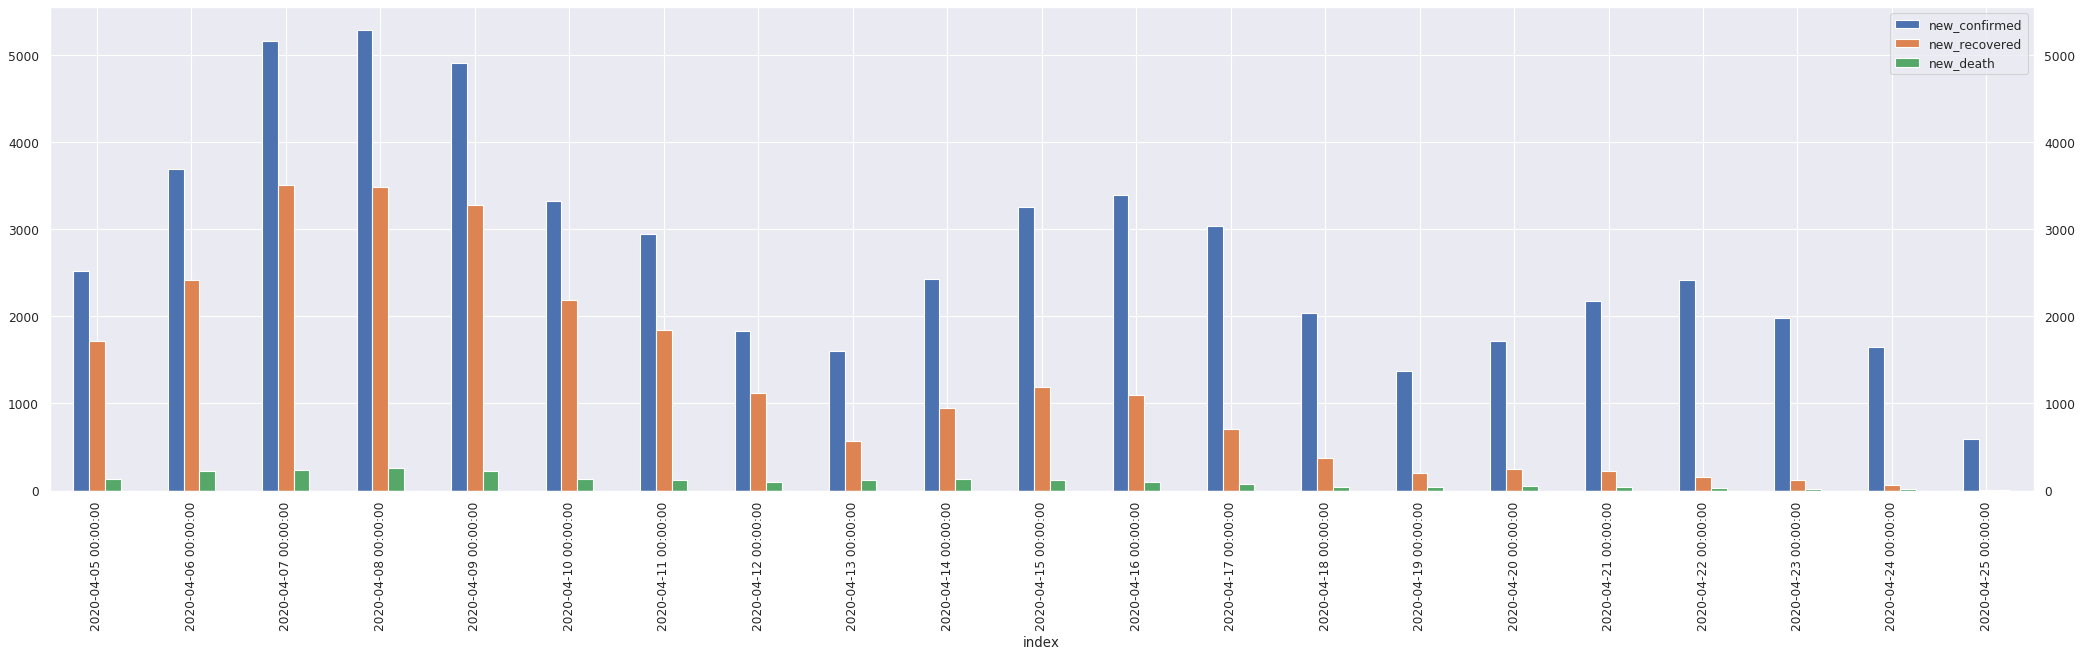

In [15]:
cbr_germany.plot_daily_stats()

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.


> Roughly 2020-04-21 the taken actions show clear effect; roughly 4.5 weeks later.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |
| 2020-04-15 | - | - | 0.029 | 3451 |
| 2020-04-16 | - | - | 0.026 | 3086 |
| 2020-04-17 | - | - | 0.024 | 2845 |
| 2020-04-19 | - | - | 0.021 | 2666 |
| 2020-04-20 | - | - | 0.020 | 2554 |
| 2020-04-21 | - | - | 0.018 | 2356 |
| 2020-04-24 | - | - | 0.015 | 2043 |
| 2020-04-25 | 2020-05-24 | 166654 | 0.011 | - |
| 2020-04-26 | 2020-05-26 | 167739 | 0.010 | - |

In [16]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


In [17]:
# cbr_germany.fit_df0.loc[pd.to_datetime('2020-05-24')]

sigmoid+asymmetric: seor: 959.4253414014389, max asymptotic: 167738.61999781049; growth-rate: 0.01006730801629474, date:2020-05-26 00:00:00, projected value: 83.22929592590305


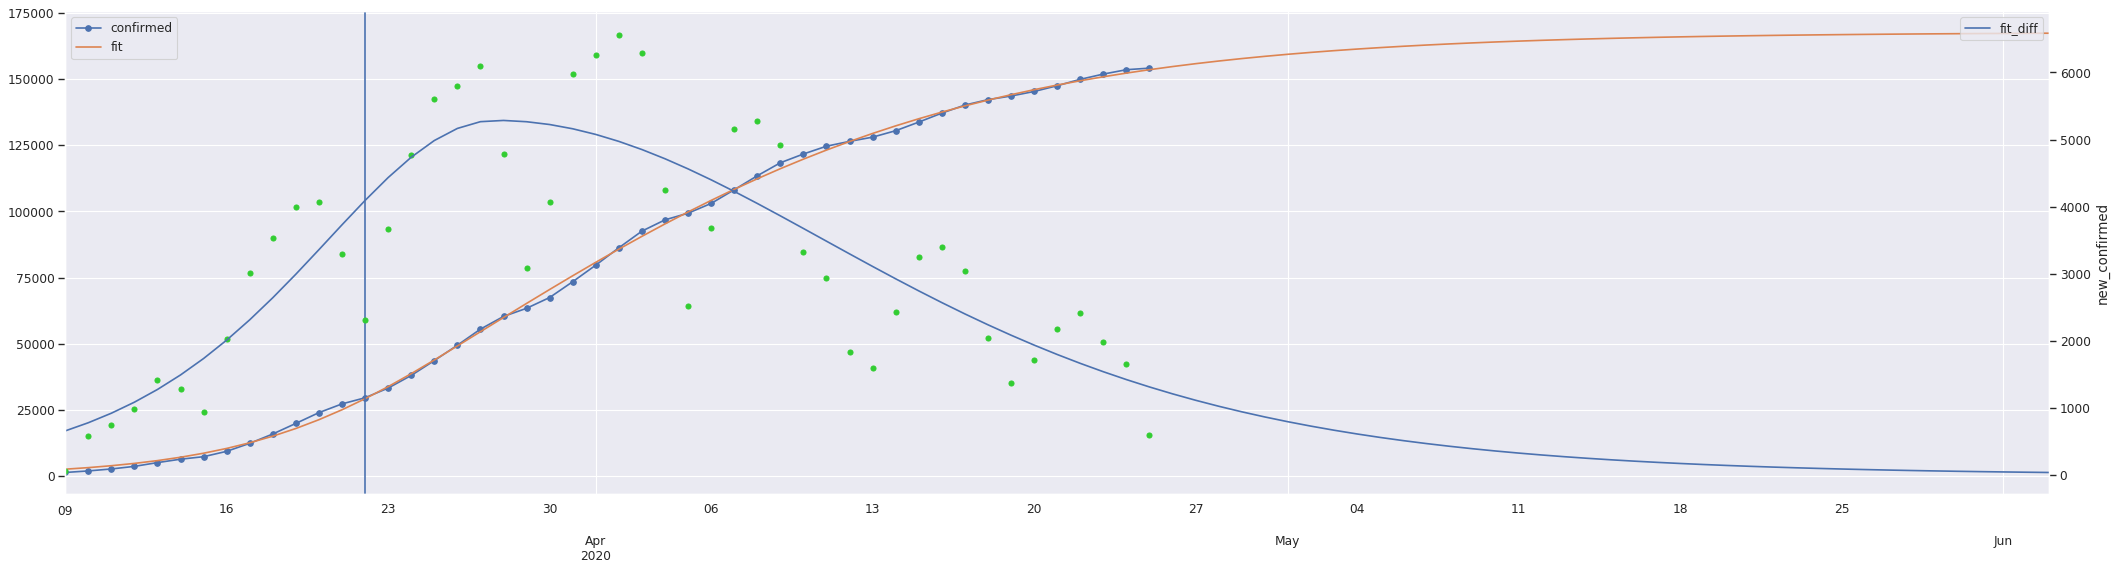

In [18]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [19]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5284.885637


In [21]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-23,0.51,0.789,0.494,0.659,0.652


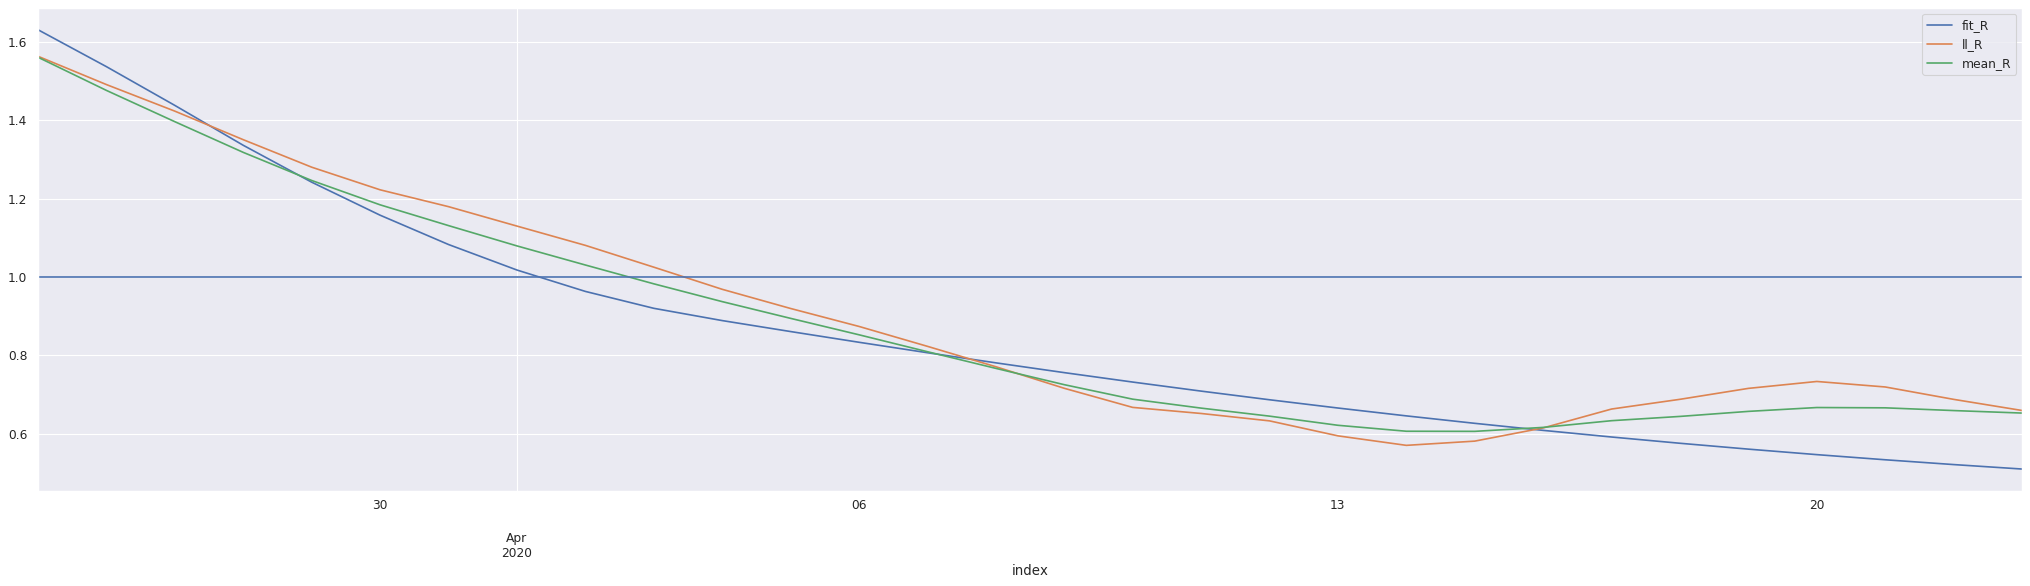

In [22]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [30]:
cbr_austria = covid19.CasesByRegion('Austria')
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,14942,11328,510,62,357,19
2020-04-22,15005,11694,522,63,366,12
2020-04-23,15051,11872,530,46,178,8
2020-04-24,15071,11872,530,20,0,0
2020-04-25,15148,12103,536,77,231,6


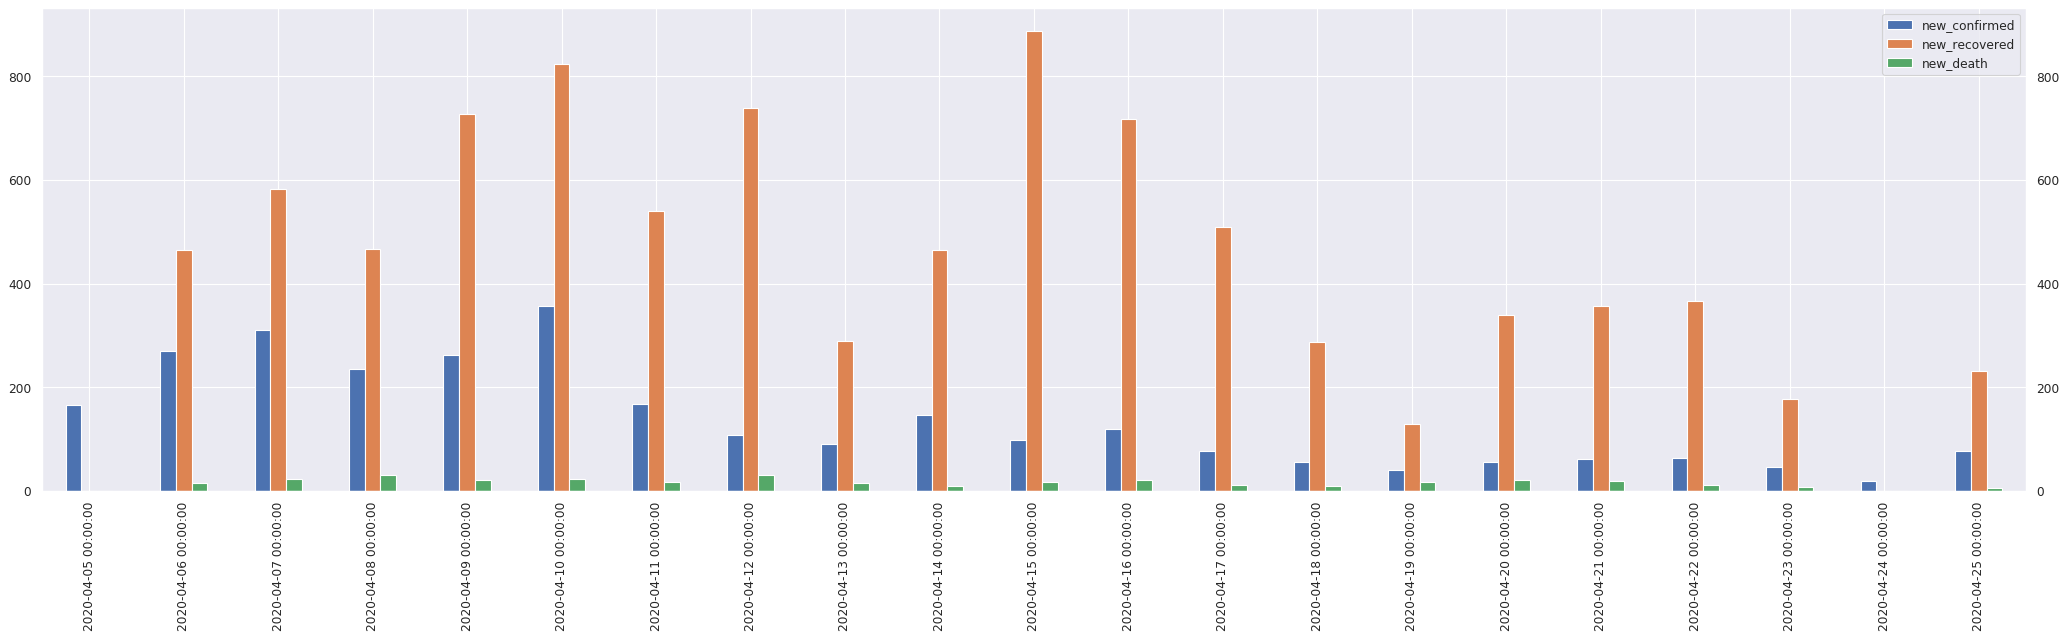

In [31]:
cbr_austria.plot_daily_stats()

[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |
| 2020-04-15 | - | - | 0.010 | 114 |
| 2020-04-15 | - | - | 0.009 | 107 |
| 2020-04-17 | - | - | 0.009 | 106 |
| 2020-04-19 | - | - | 0.007 |  95 |
| 2020-04-20 | - | - | 0.007 |  87 |
| 2020-04-21 | - | - | 0.006 |  83 |
| 2020-04-24 | - | - | 0.005 |  68 |
| 2020-04-26 | 2020-05-01 | 15208 | 0.002 |  - |

In [32]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland
einwohner_österreich  =  8793370.0
prozent_österreich    = einwohner_österreich / einwohner_deutschland

austria_new_confirmed_threshold = (100.0 * prozent_österreich) // 1 + 1
austria_new_confirmed_threshold

11.0

In [33]:
cbr_austria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=austria_new_confirmed_threshold)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 87.51638498176715, max asymptotic: 15207.673018283747; growth-rate: 0.002215839270375275, date:2020-05-01 00:00:00, projected value: 8.189609049113264


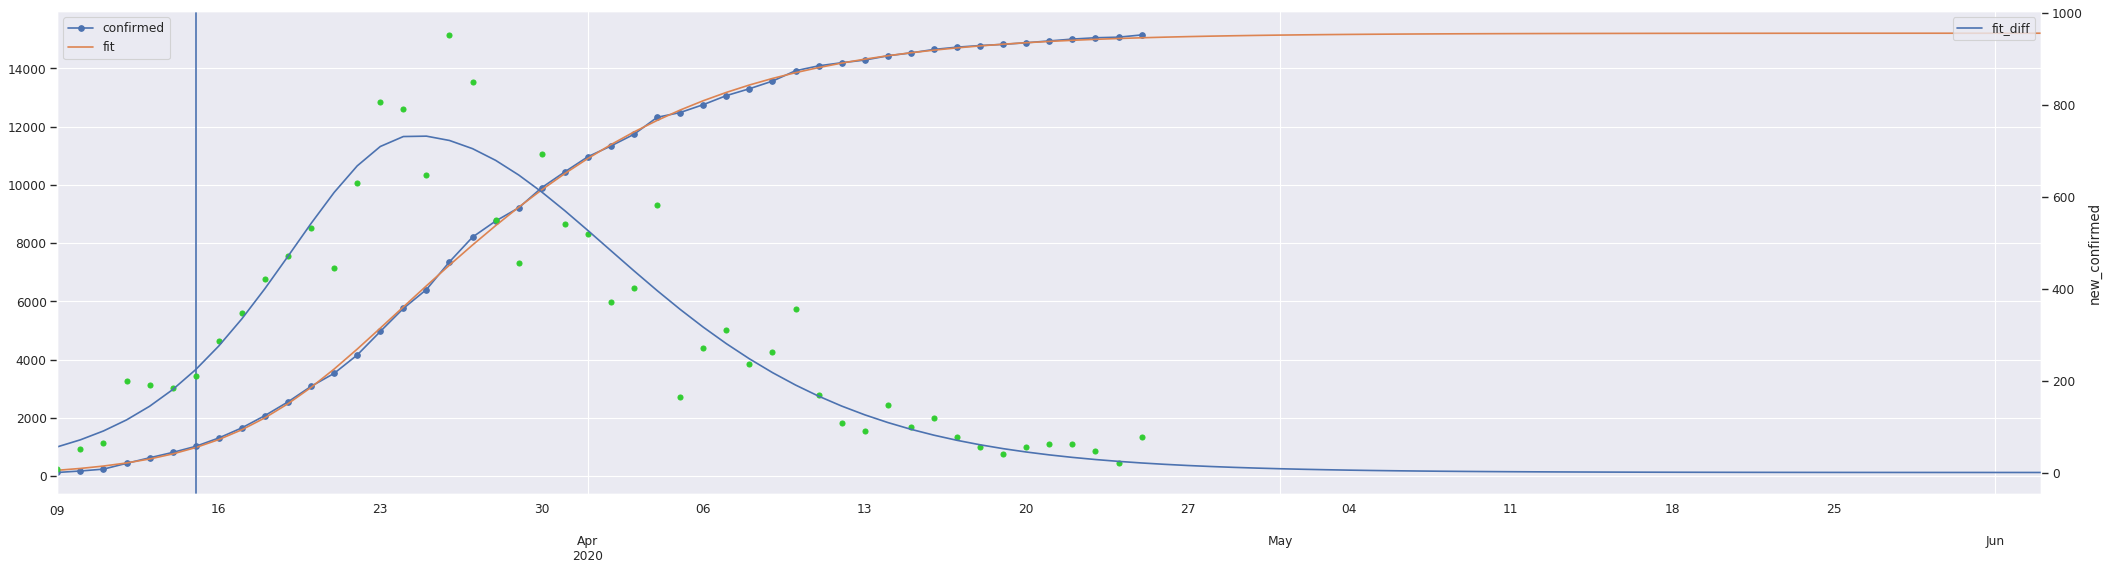

In [34]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 15))

In [35]:
cbr_austria.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,731.775417


In [36]:
cbr_austria.calculate_R_estimates()
cbr_austria.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-23,0.022,0.212,0.062,0.168,0.134


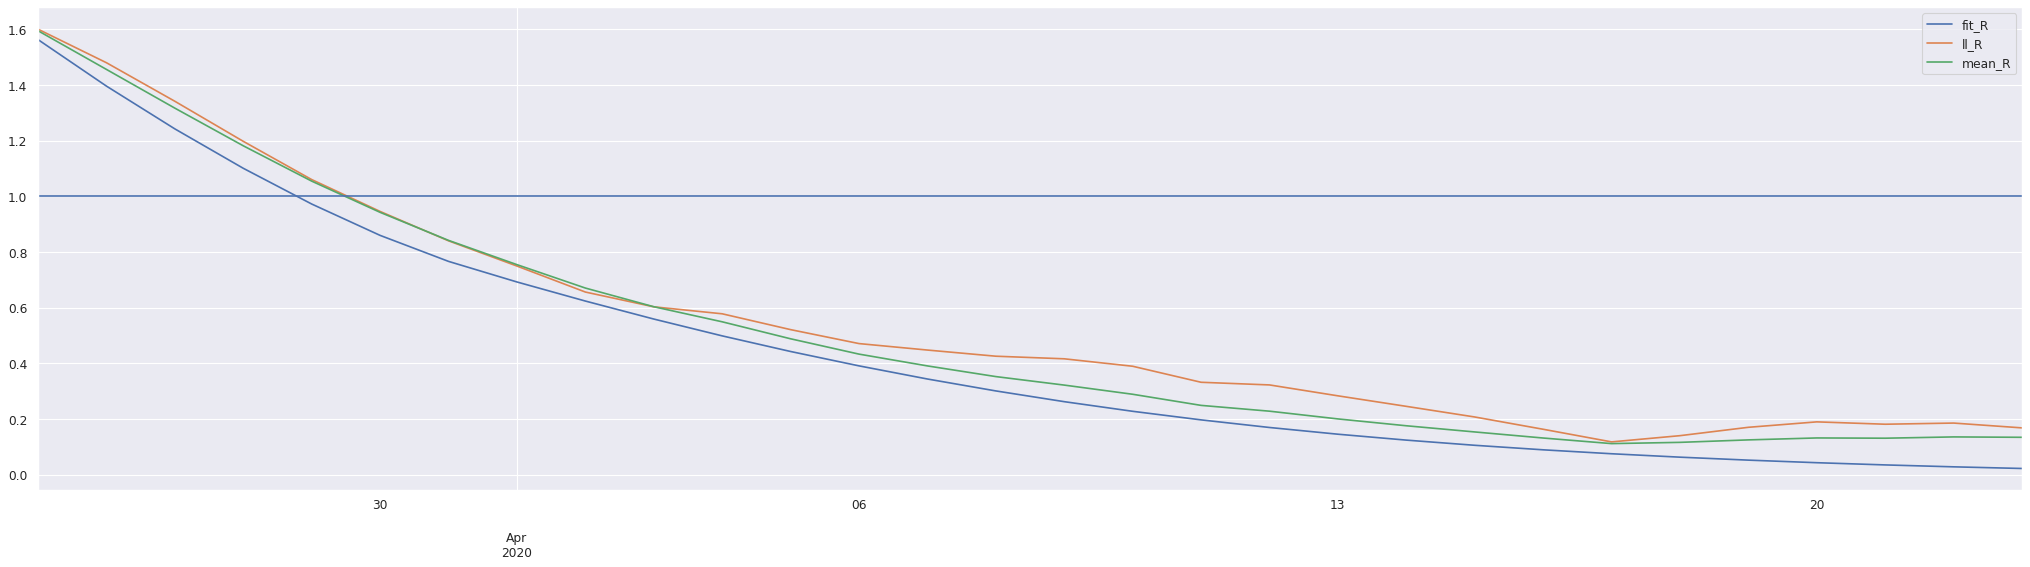

In [37]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

In [39]:
cbr_denmark = covid19.CasesByRegion('Denmark')
cbr_denmark.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,7891,4889,370,180,390,6
2020-04-22,8108,5276,384,217,387,14
2020-04-23,8271,5573,394,163,297,10
2020-04-24,8408,5715,403,137,142,9
2020-04-25,8643,5858,418,235,143,15


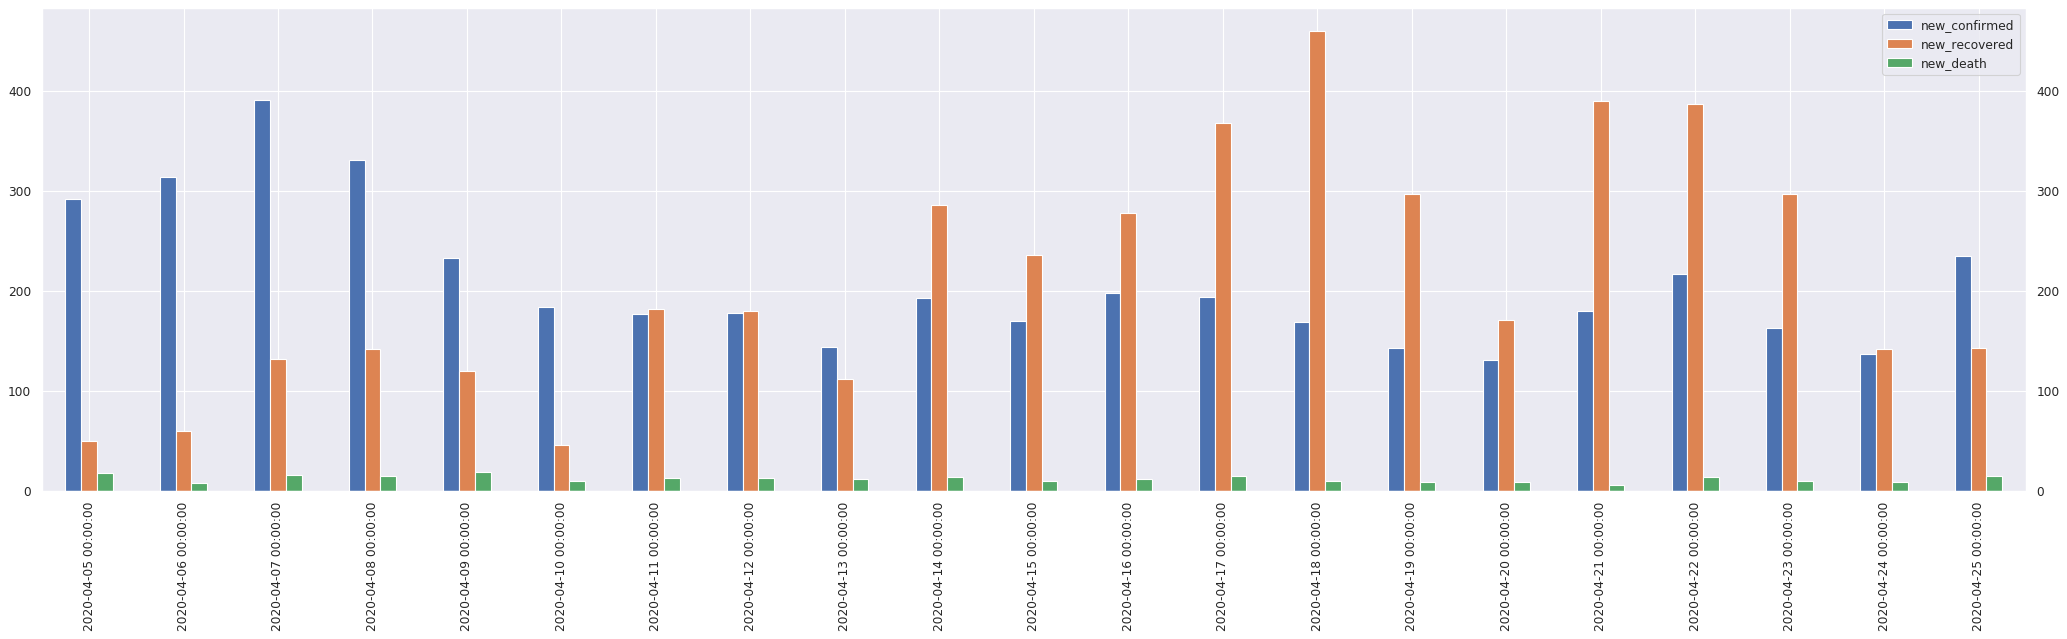

In [103]:
cbr_denmark.plot_daily_stats()

8.0
sigmoid+asymmetric+linear: seor: 28.67355086224173; growth-rate: 0.025, date:2020-06-03 00:00:00, projected value: 173.37297692669


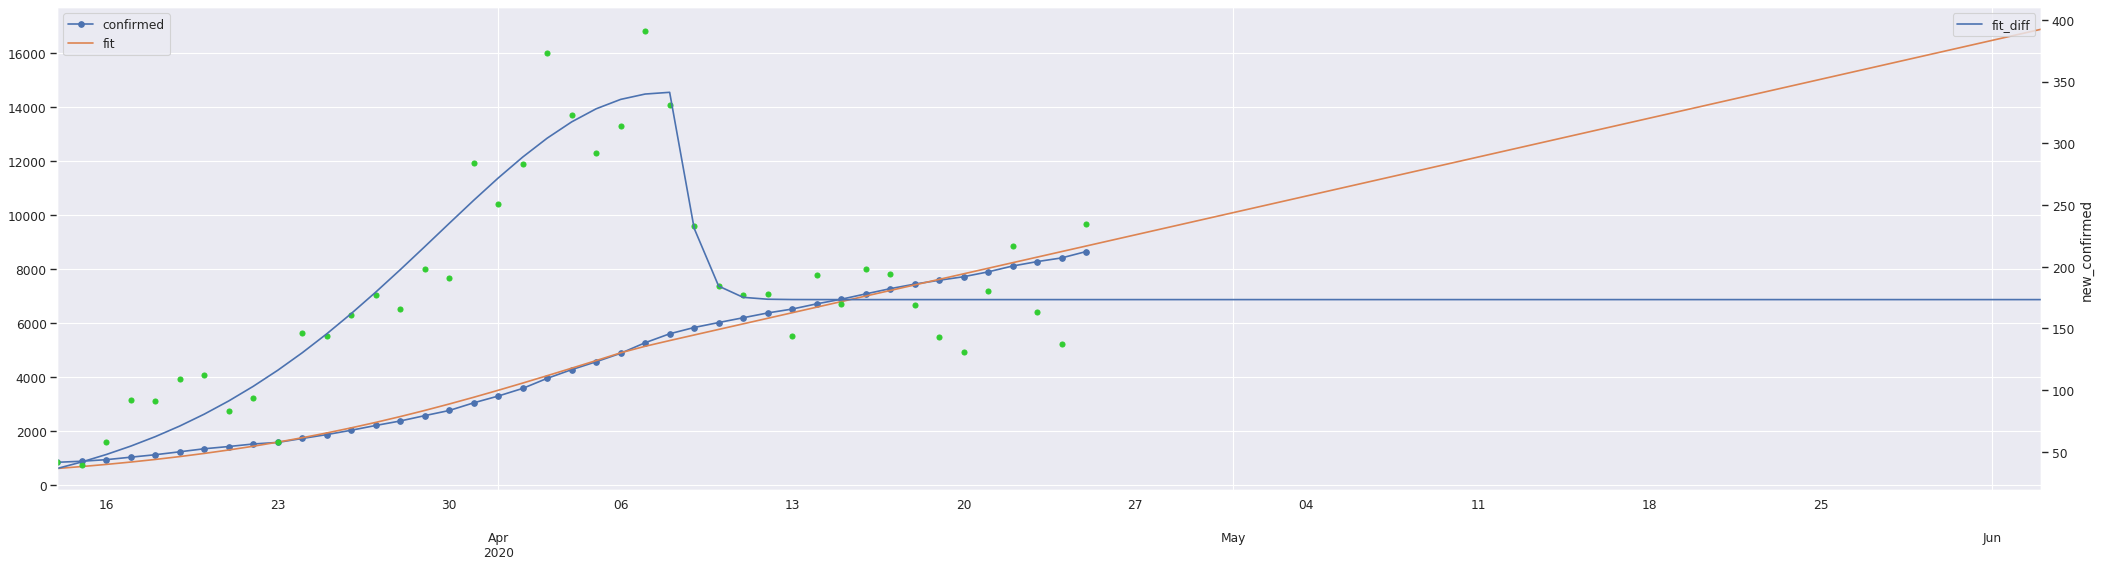

In [104]:
population_denmark  =  5822763.0
percent_denmark     = population_denmark / einwohner_deutschland

denmark_new_confirmed_threshold = (100.0 * percent_denmark) // 1 + 1
print(denmark_new_confirmed_threshold)

# first_date=pd.to_datetime('2020-03-09')
# first_date=pd.to_datetime('2020-03-14')
cbr_denmark.fit(first_date=pd.to_datetime('2020-03-14'), new_confirmed_threshold=denmark_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [105]:
cbr_denmark.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,341.401385


In [106]:
cbr_denmark.calculate_R_estimates()
cbr_denmark.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-23,1.0,1.009,0.946,0.917,0.976


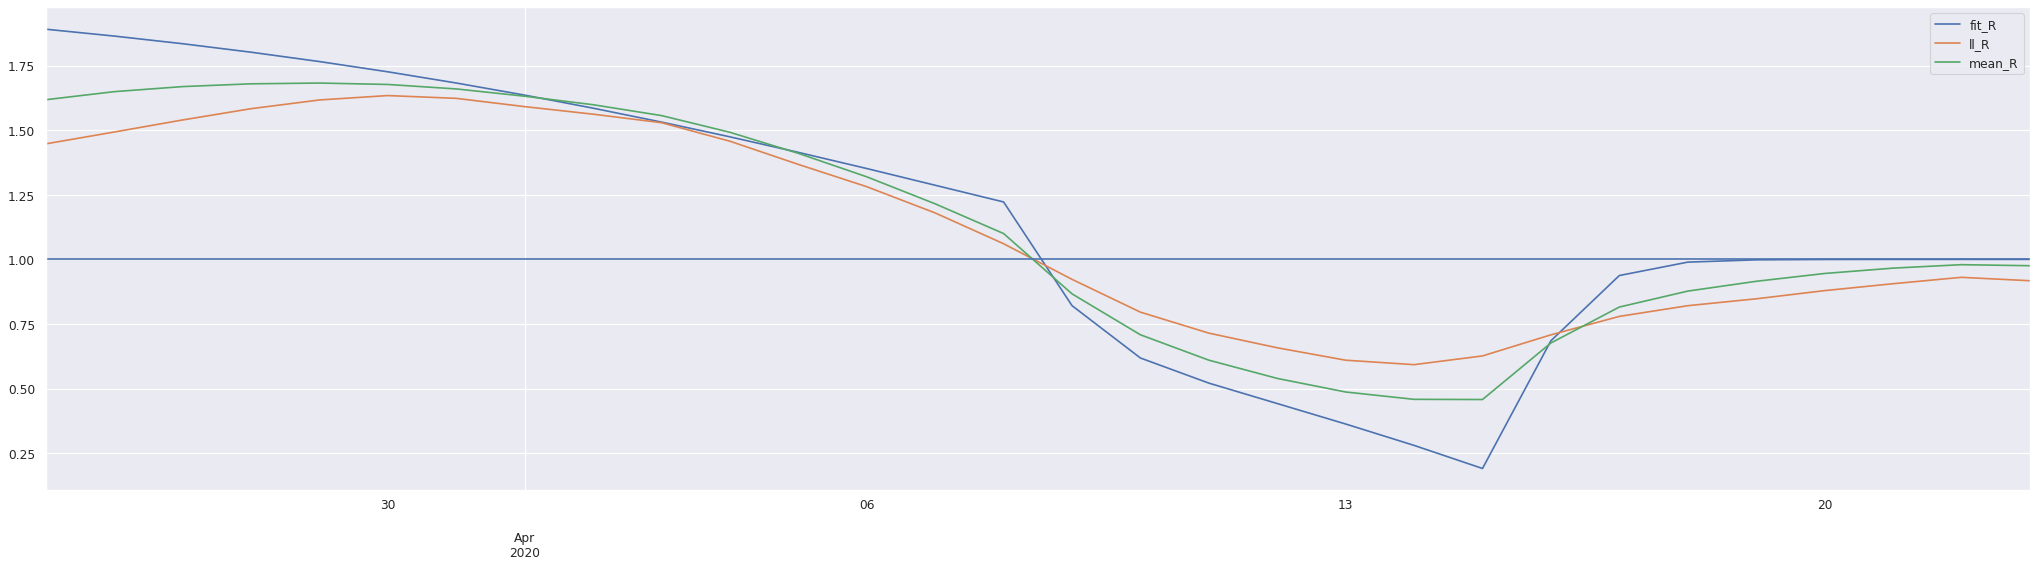

In [107]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_R(ax=ax) # , plot_start_date='2020-03-10'

There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [45]:
df = covid19.get_italy_df()
cbr_italy = covid19.CasesByRegion('Italy', df=df)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-04-21,183957,51600,24648,2729,2723,534
2020-04-22,187327,54543,25085,3370,2943,437
2020-04-23,189973,57576,25549,2646,3033,464
2020-04-24,192994,60498,25969,3021,2922,420
2020-04-25,195351,63120,26384,2357,2622,415


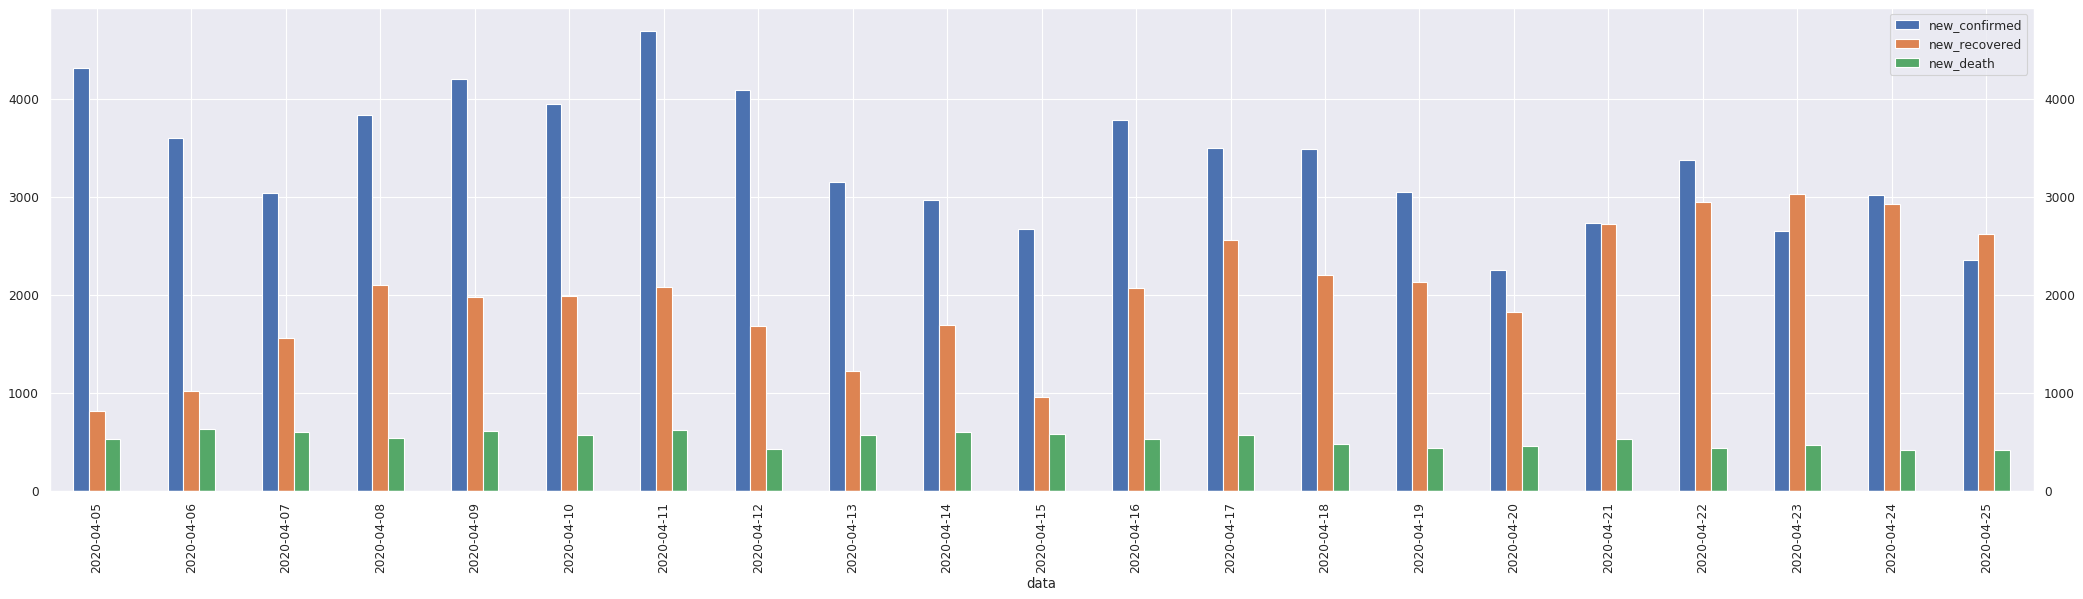

In [46]:
cbr_italy.plot_daily_stats()

In [47]:
cbr_italy.fit(first_date=pd.to_datetime('2020-02-21'))

sigmoid+asymmetric+linear: seor: 493.2335718595154; growth-rate: 0.016260805072370488, date:2020-06-03, projected value: 2719.9195313888936


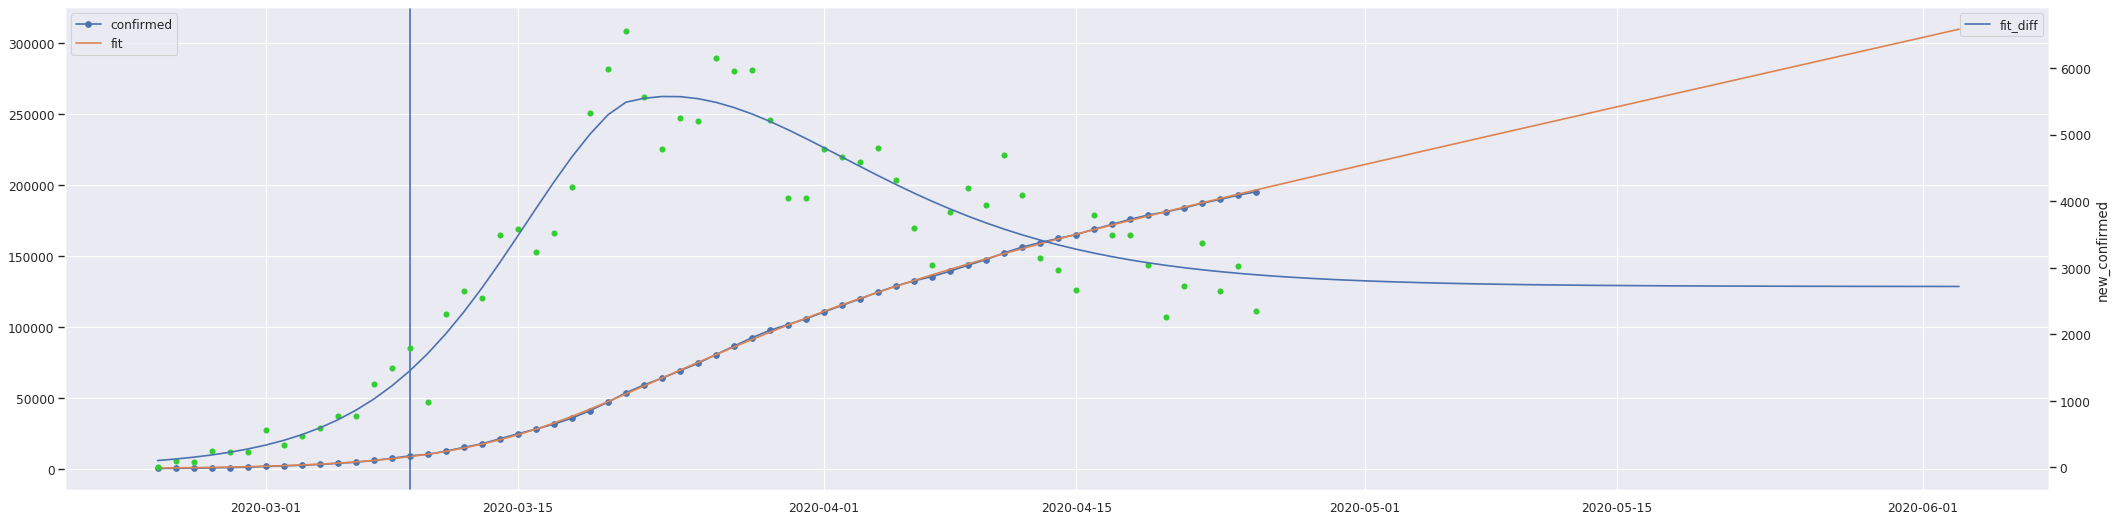

In [48]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 9))

In [49]:
cbr_italy.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5573.946927


In [50]:
cbr_italy.calculate_R_estimates()
cbr_italy.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
data,,,,,
2020-04-23,0.91,0.852,0.741,0.835,0.865


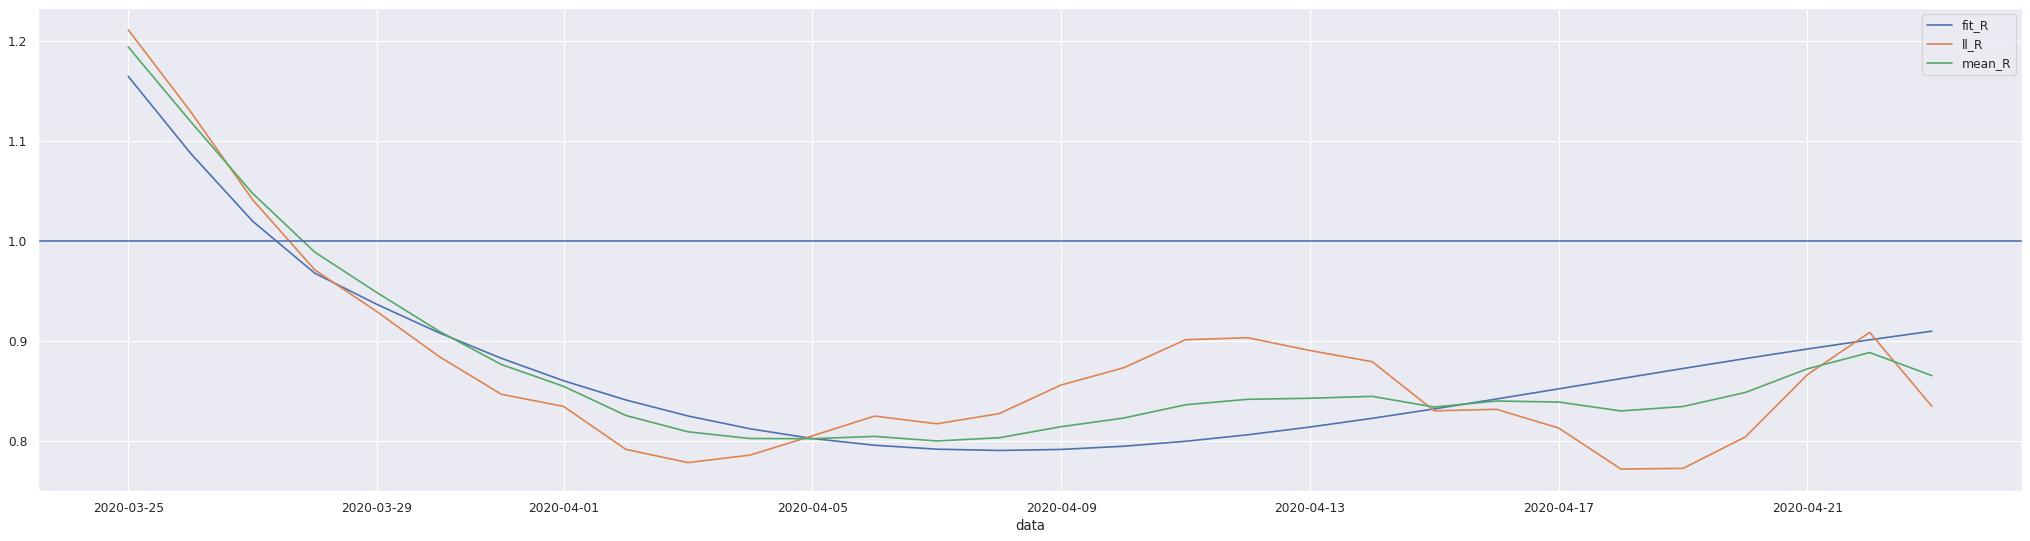

In [51]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)


* [mscbs.gob.es](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm)
* https://covid19.isciii.es/
* [github/datadista](https://github.com/datadista/datasets/tree/master/COVID%2019)

In [52]:
df = covid19.get_spain_df()
cbr_spain = covid19.CasesByRegion('Spain', df=df)
cbr_spain.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-21,204178,82514,21282,3968,1927,430
2020-04-22,208389,85915,21717,4211,3401,435
2020-04-23,213024,89250,22157,4635,3335,440
2020-04-24,219764,92355,22524,6740,3105,367
2020-04-25,223759,95708,22902,3995,3353,378


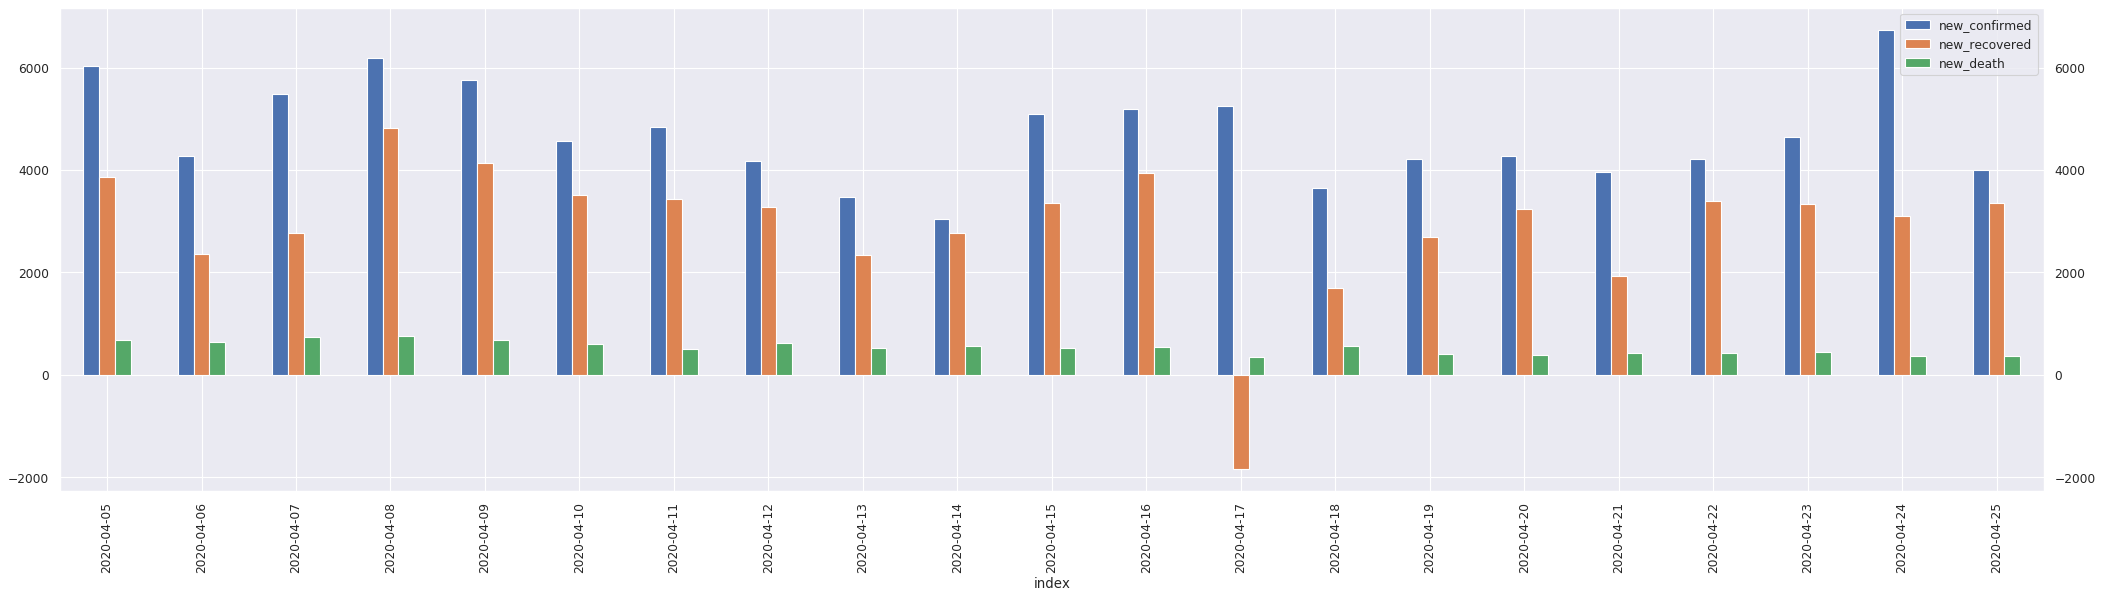

In [53]:
cbr_spain.plot_daily_stats()

In [54]:
cbr_spain.fit(first_date=pd.to_datetime('2020-03-04'))

sigmoid+linear: seor: 740.8497659653531, max asymptotic: 103190.5654845991; growth-rate: 0.0197381590549639, date:2020-06-03, projected value: 4095.430703957865


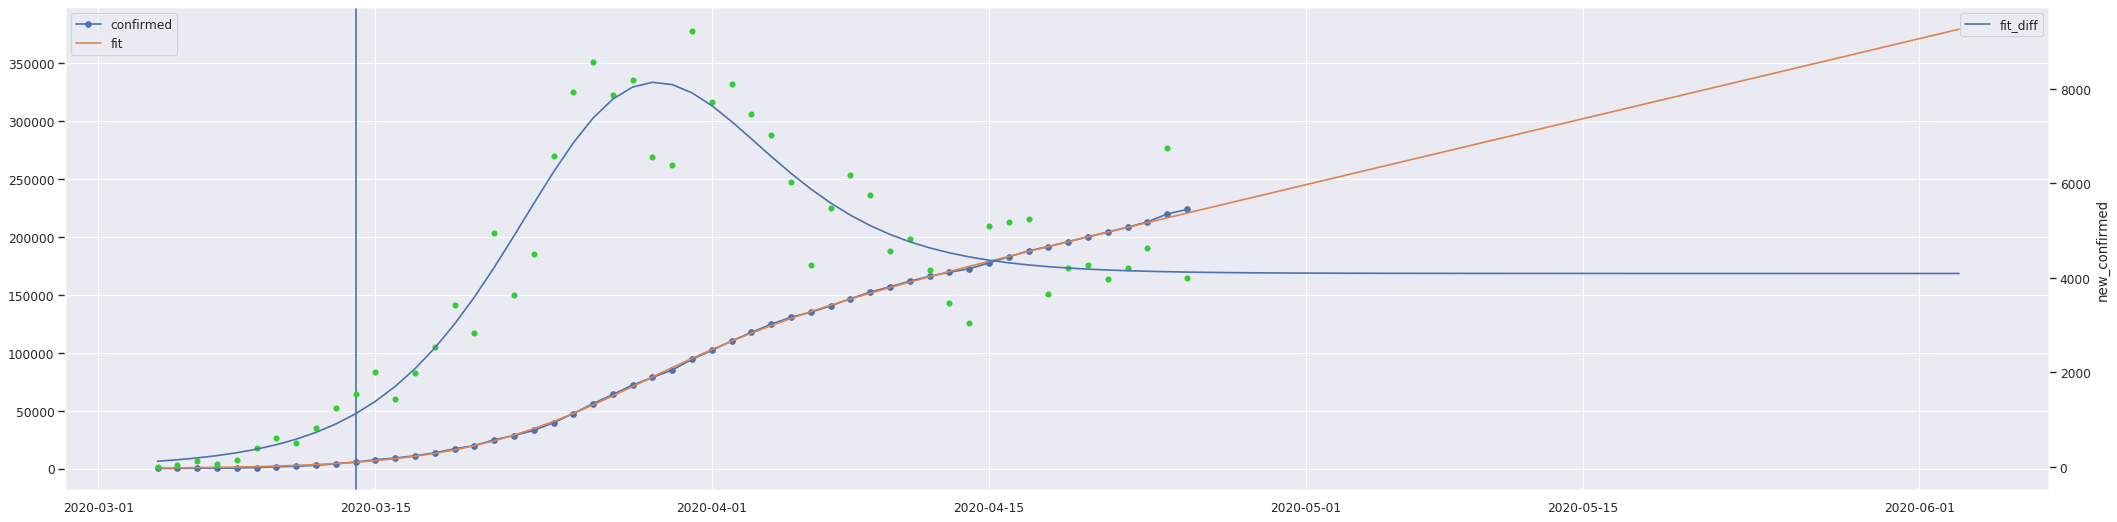

In [55]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [56]:
cbr_spain.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,8139.172419


In [57]:
cbr_spain.calculate_R_estimates()
cbr_spain.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-04-23,0.958,0.994,0.861,0.93,0.961


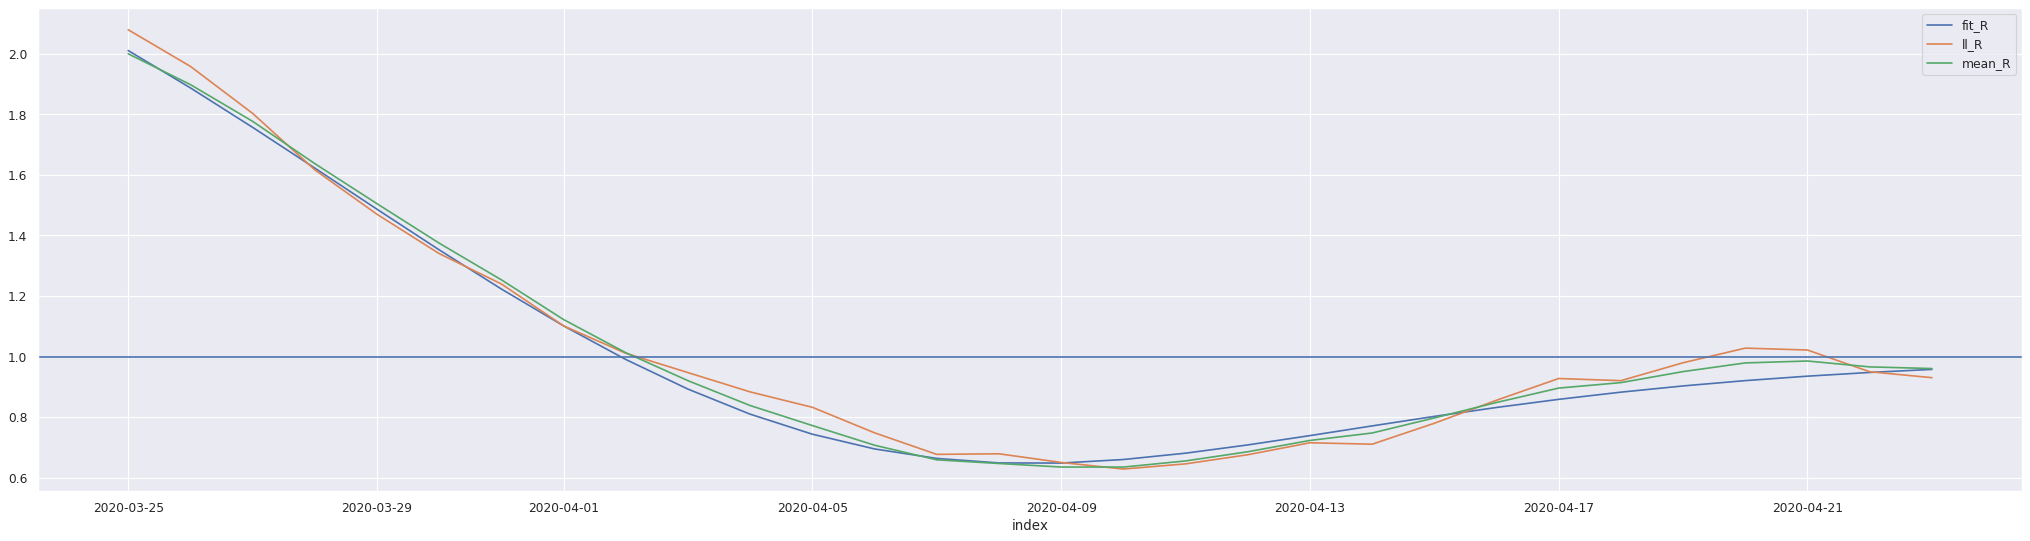

In [58]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)



* [opencovid19-fr / data](https://github.com/opencovid19-fr/data/blob/master/README.en.md)
    * [chiffres-cles.csv](https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv)
    * [dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/5e09dff7cb434fb194e22261689e2887)
    * [santepubliquefrance](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde)

In [59]:
df =covid19.get_france_df()
cbr_france = covid19.CasesByRegion('France', df=df)
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-04-21,117324.0,39181.0,20796.0,2667.0,1772.0,531.0
2020-04-22,119151.0,40657.0,21340.0,1827.0,1476.0,544.0
2020-04-23,120804.0,42088.0,21856.0,1653.0,1431.0,516.0
2020-04-24,122577.0,43493.0,22245.0,1773.0,1405.0,389.0
2020-04-25,124114.0,44594.0,22614.0,1537.0,1101.0,369.0


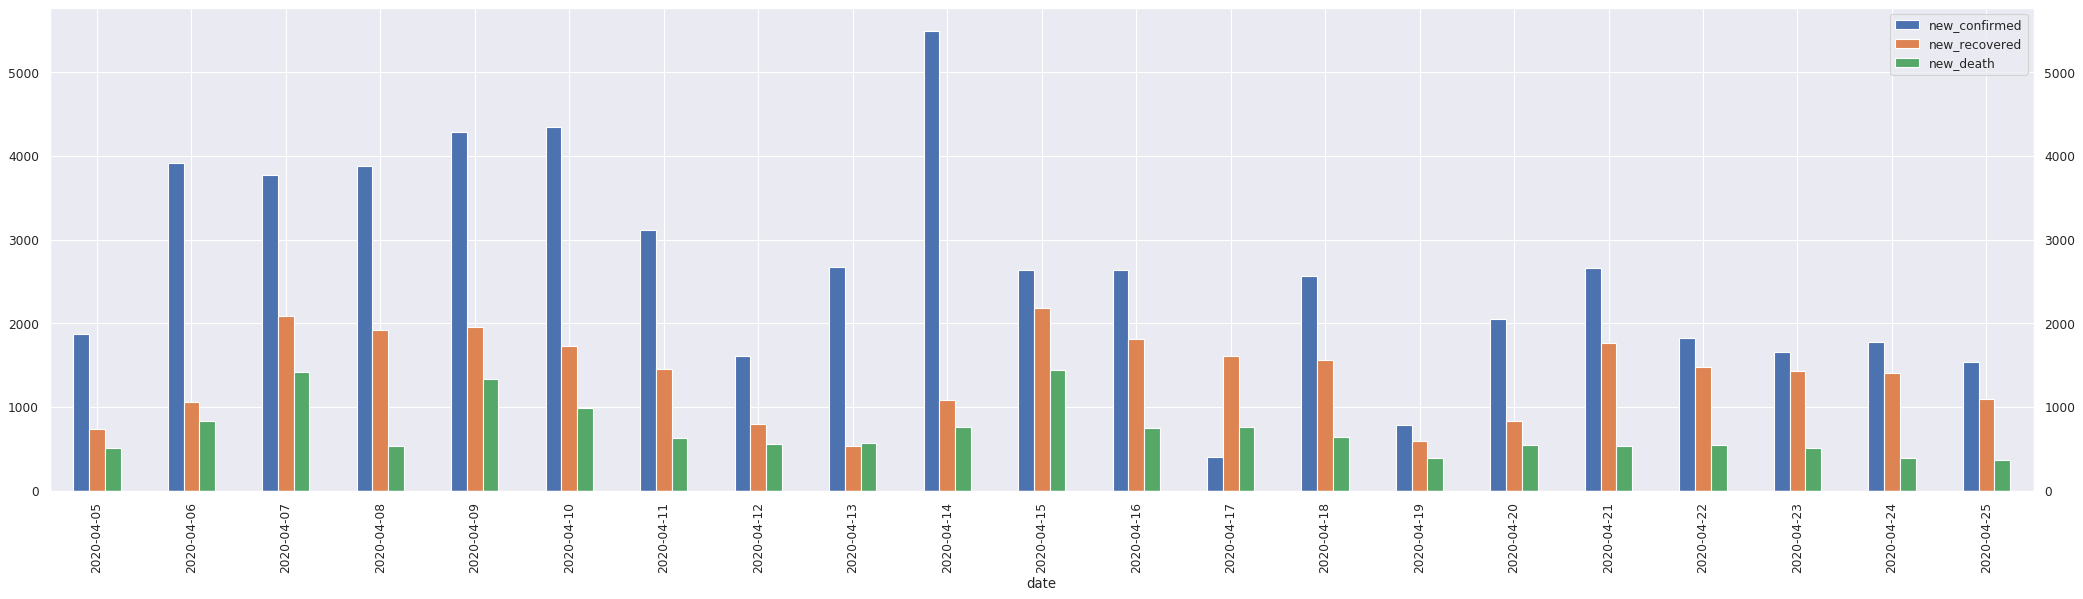

In [60]:
cbr_france.plot_daily_stats()

In [61]:
cbr_france.fit(first_date=pd.to_datetime('2020-03-04'))

sigmoid+asymmetric: seor: 1006.3062325426555, max asymptotic: 138154.78138147574; growth-rate: 0.012901197083863725, date:2020-05-24, projected value: 86.27278095139532


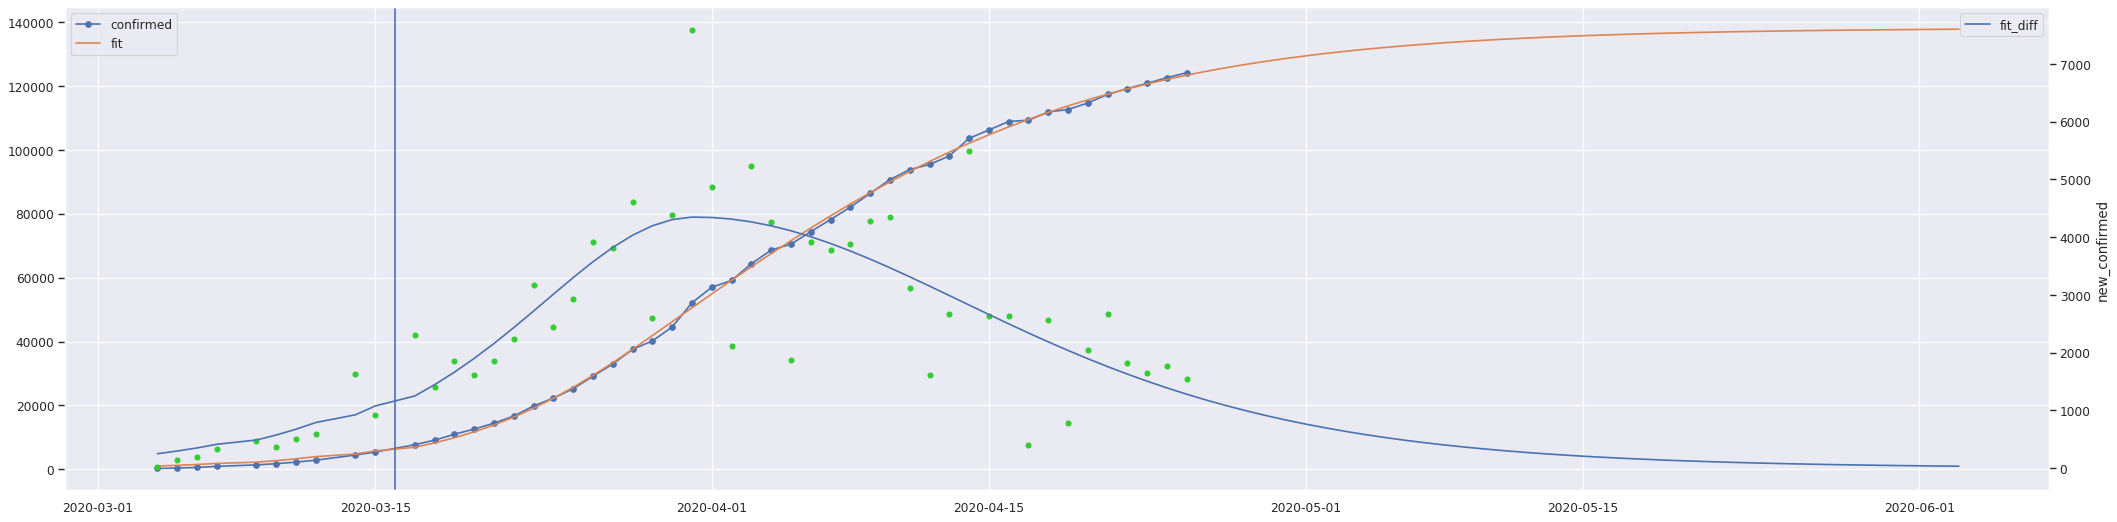

In [62]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 16))

In [63]:
cbr_france.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4346.229547


In [64]:
cbr_france.calculate_R_estimates()
cbr_france.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
date,,,,,
2020-04-23,0.515,0.634,0.416,0.536,0.562


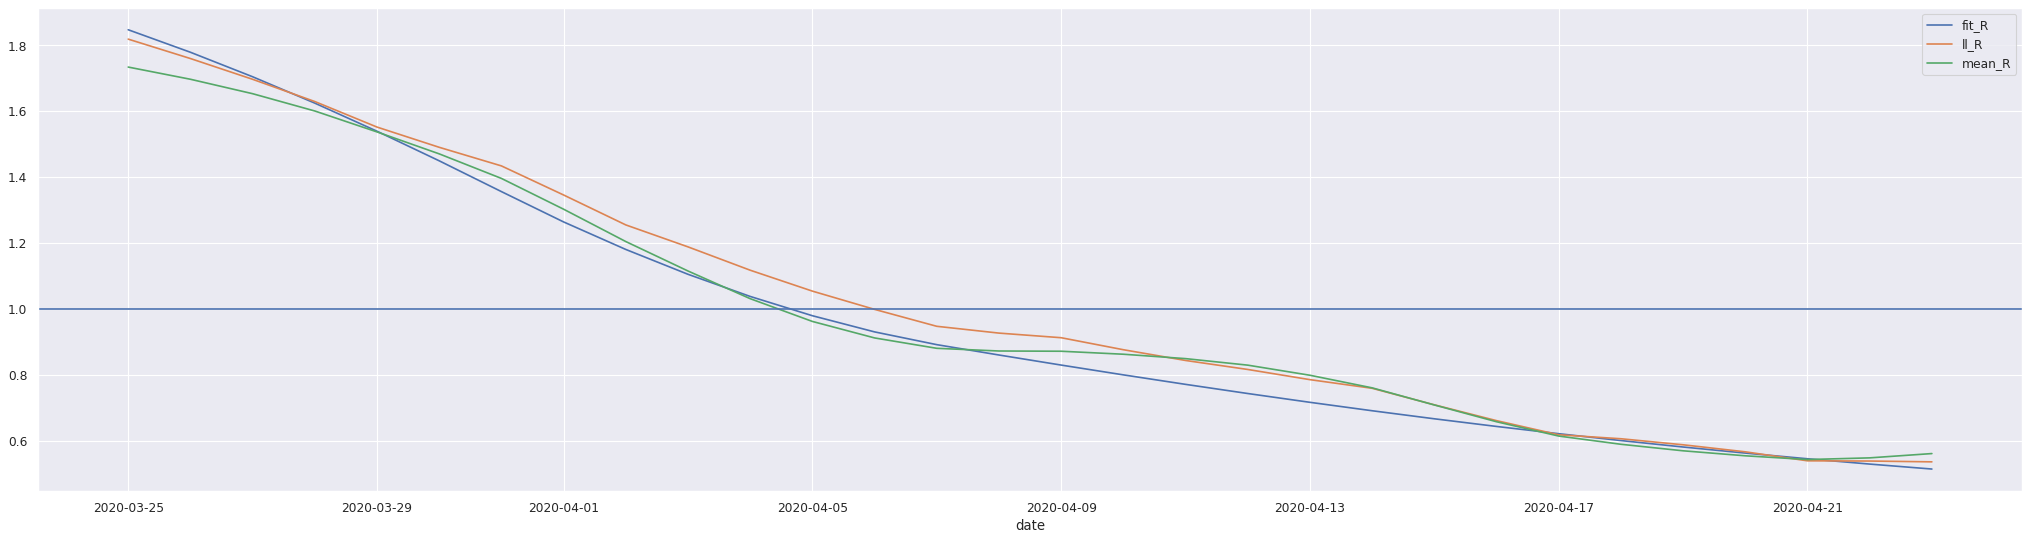

In [65]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [66]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,10683,8213,237,9,99,1
2020-04-22,10694,8277,238,11,64,1
2020-04-23,10708,8501,240,14,224,2
2020-04-24,10718,8635,240,10,134,0
2020-04-25,10728,8717,242,10,82,2


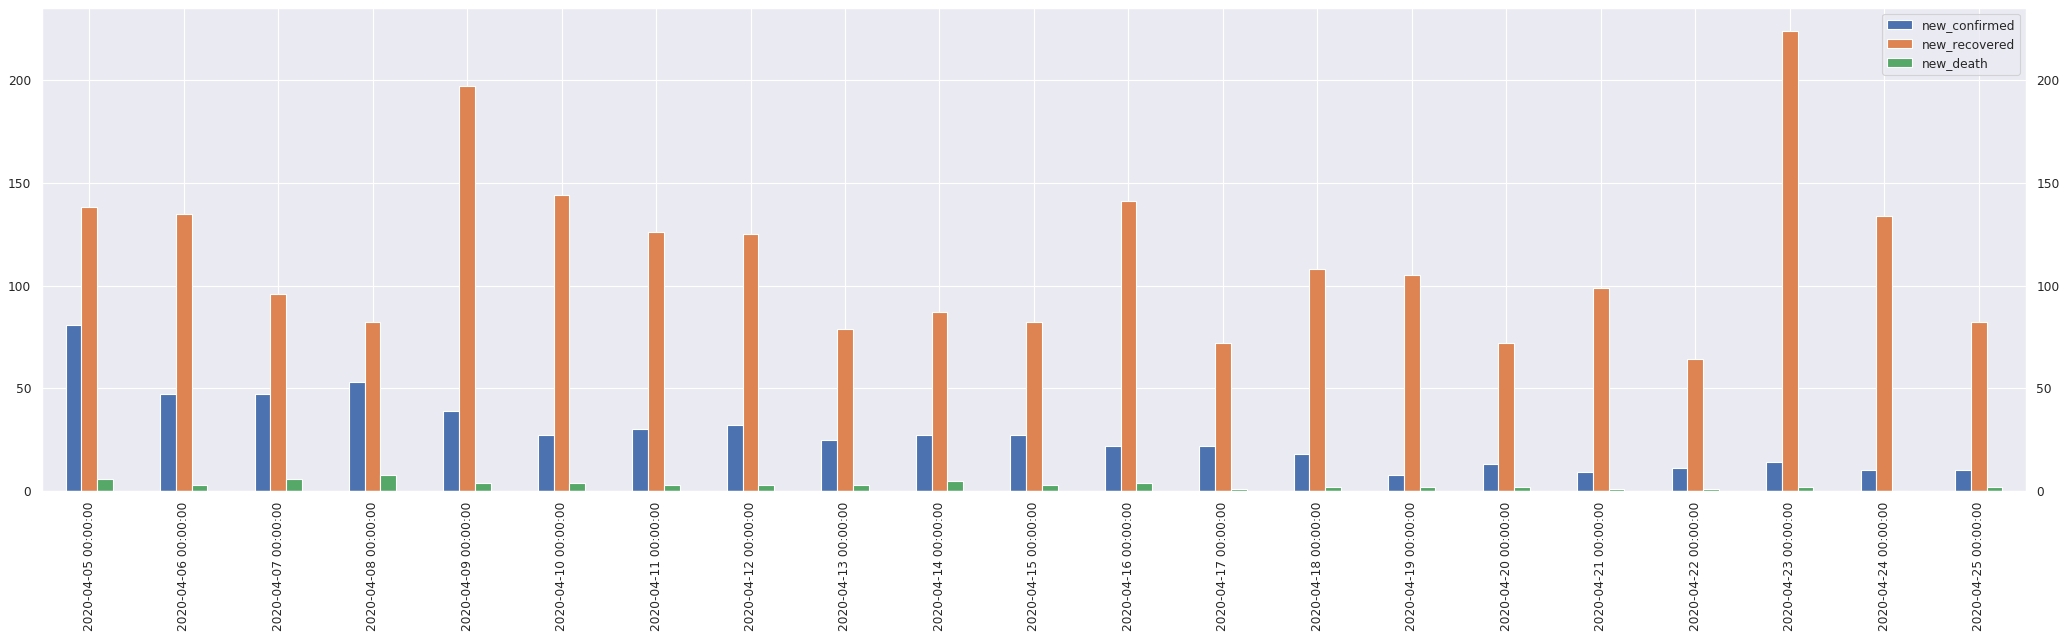

In [67]:
cbr_south_korea.plot_daily_stats()

In [68]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,130172,638,17378,4316,192,828
2020-04-22,134638,683,18151,4466,45,773
2020-04-23,139246,712,18791,4608,29,640
2020-04-24,144640,724,19567,5394,12,776
2020-04-25,149569,774,20381,4929,50,814


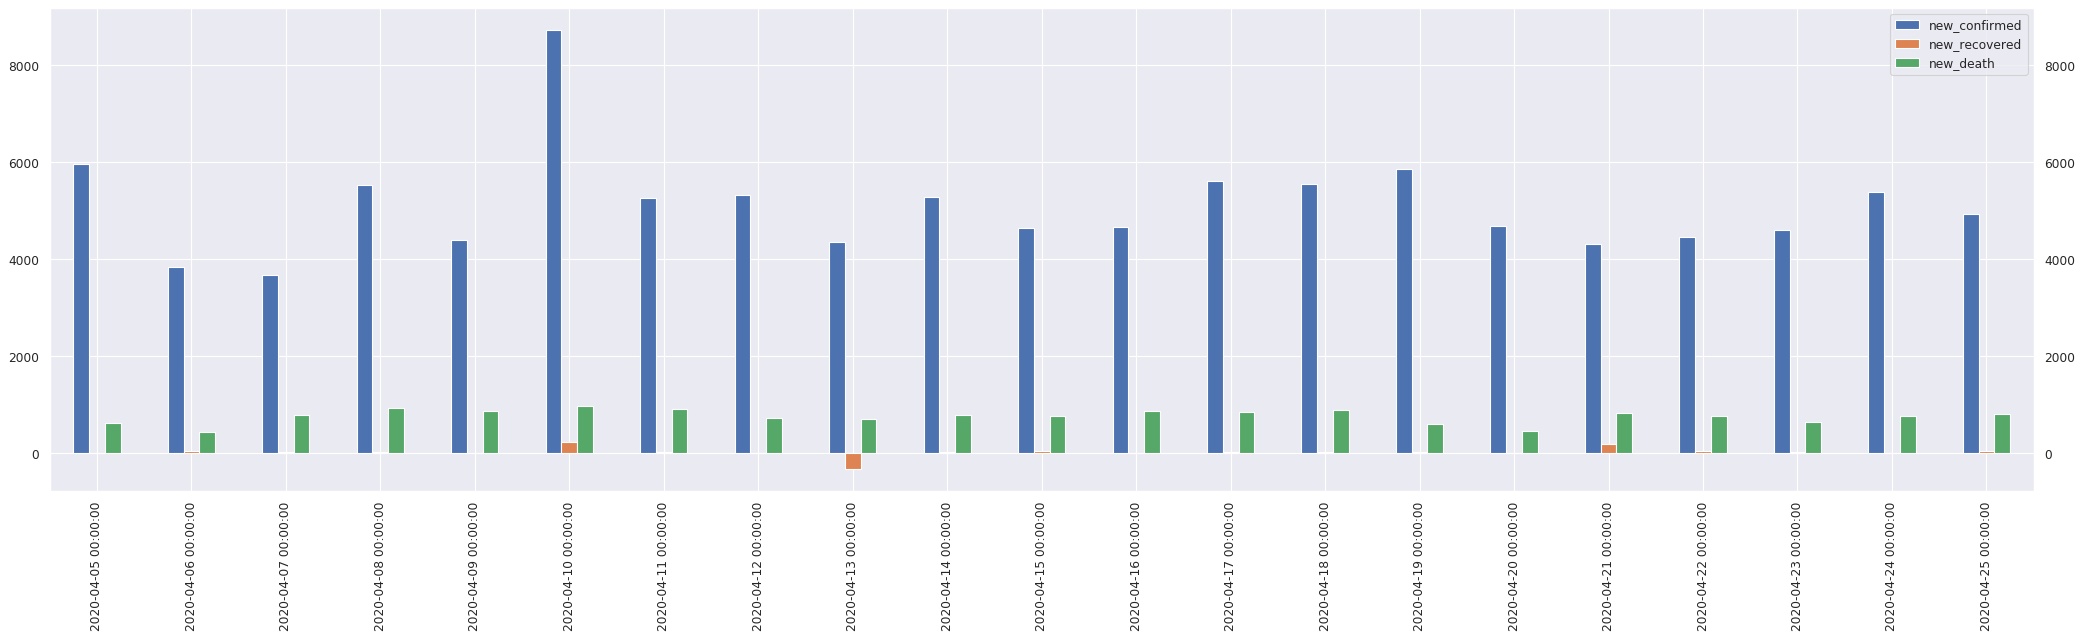

In [69]:
cbr_uk.plot_daily_stats()

In [70]:
cbr_uk.fit(first_date=pd.to_datetime('2020-03-05'))

sigmoid+asymmetric+linear: seor: 677.5860055674748; growth-rate: 0.03682721927896826, date:2020-06-03 00:00:00, projected value: 4875.460992438987


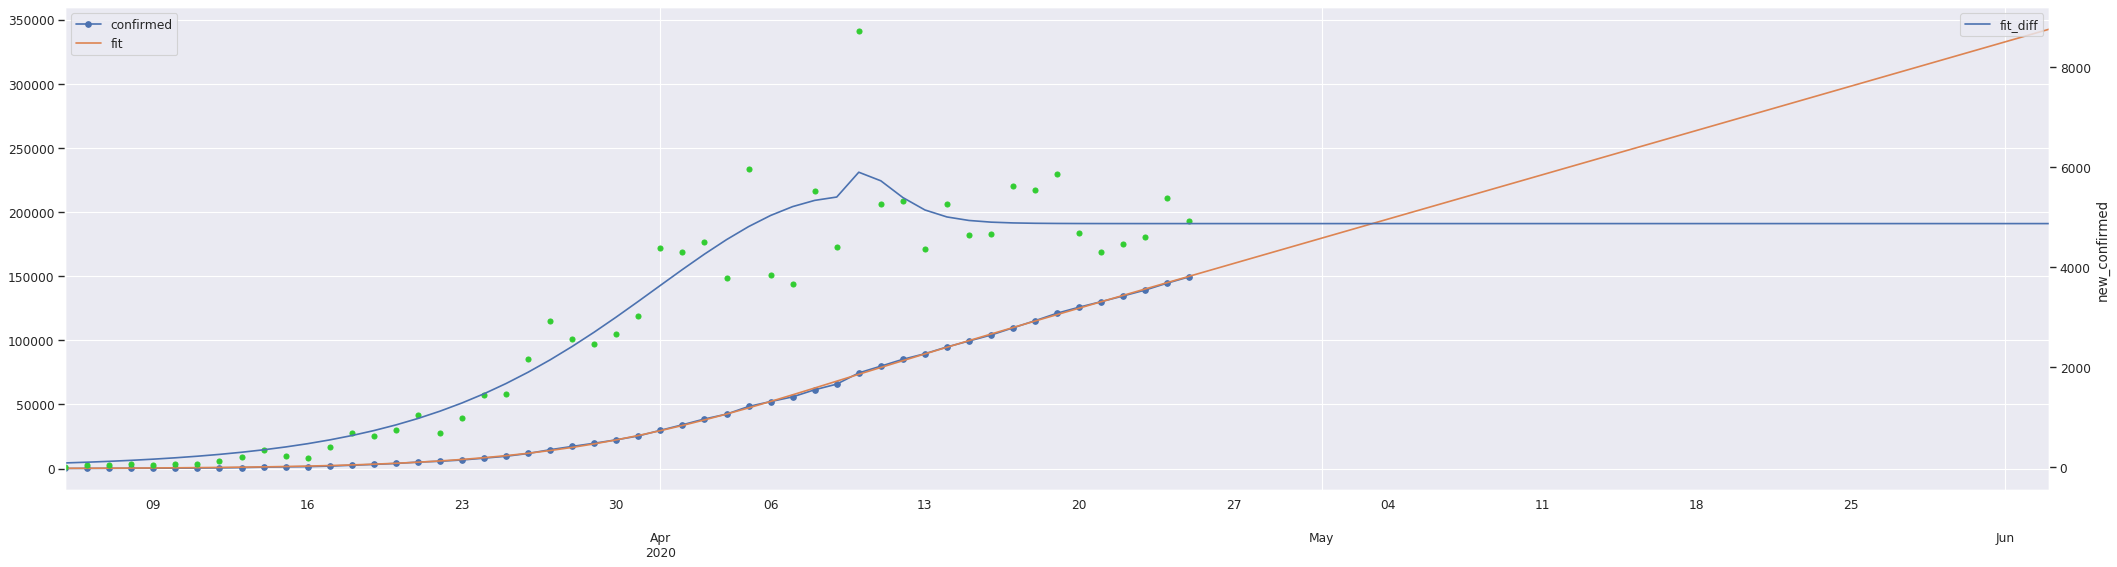

In [71]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_with_fits(ax=ax)

In [72]:
cbr_uk.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5902.715112


In [73]:
cbr_uk.calculate_R_estimates()
cbr_uk.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-23,0.994,0.979,0.967,1.248,1.074


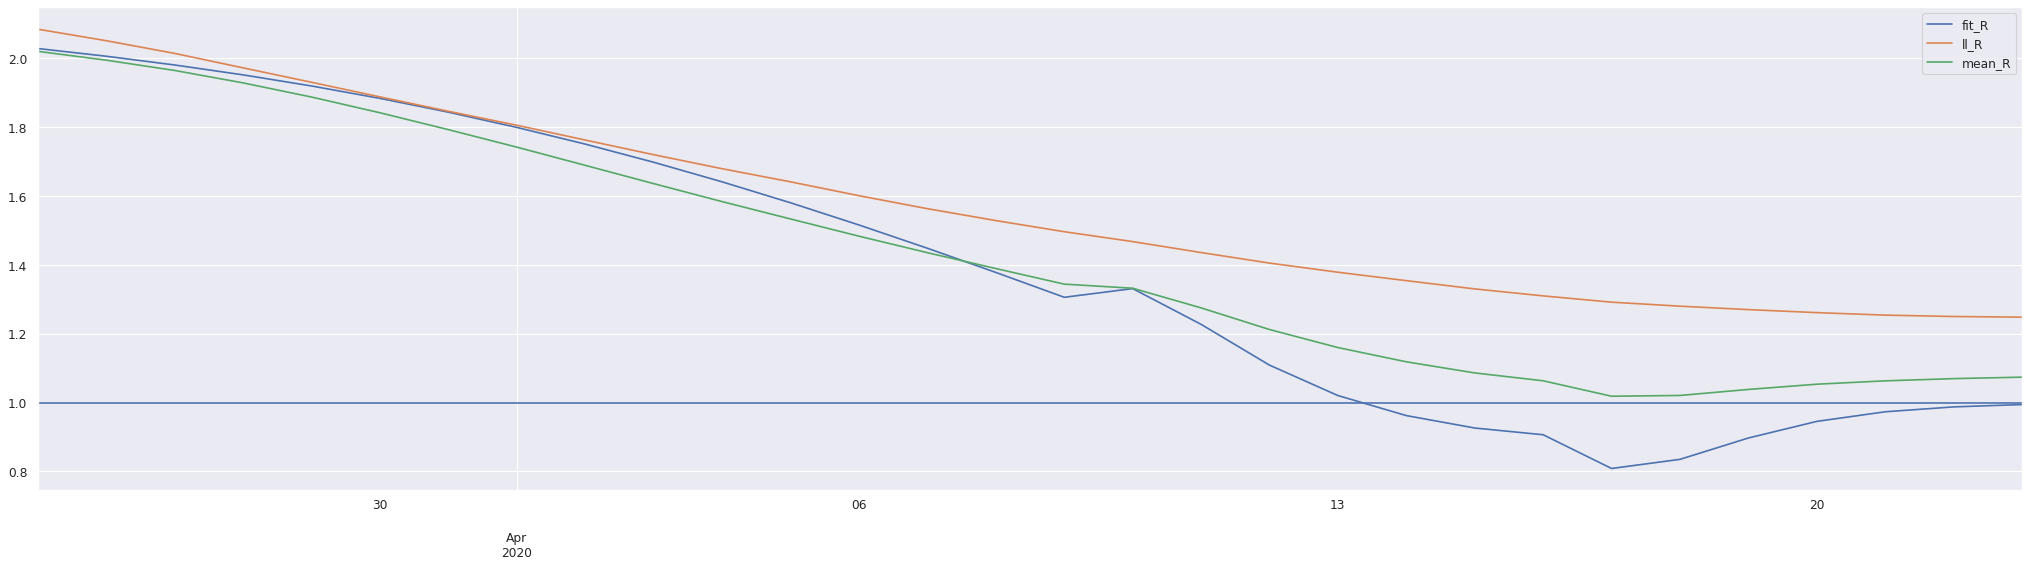

In [74]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [75]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,811865,75204,44444,27539,2875,2350
2020-04-22,840351,77366,46622,28486,2162,2178
2020-04-23,869170,80203,49954,28819,2837,3332
2020-04-24,905358,99079,51949,36188,18876,1995
2020-04-25,938154,100372,53755,32796,1293,1806


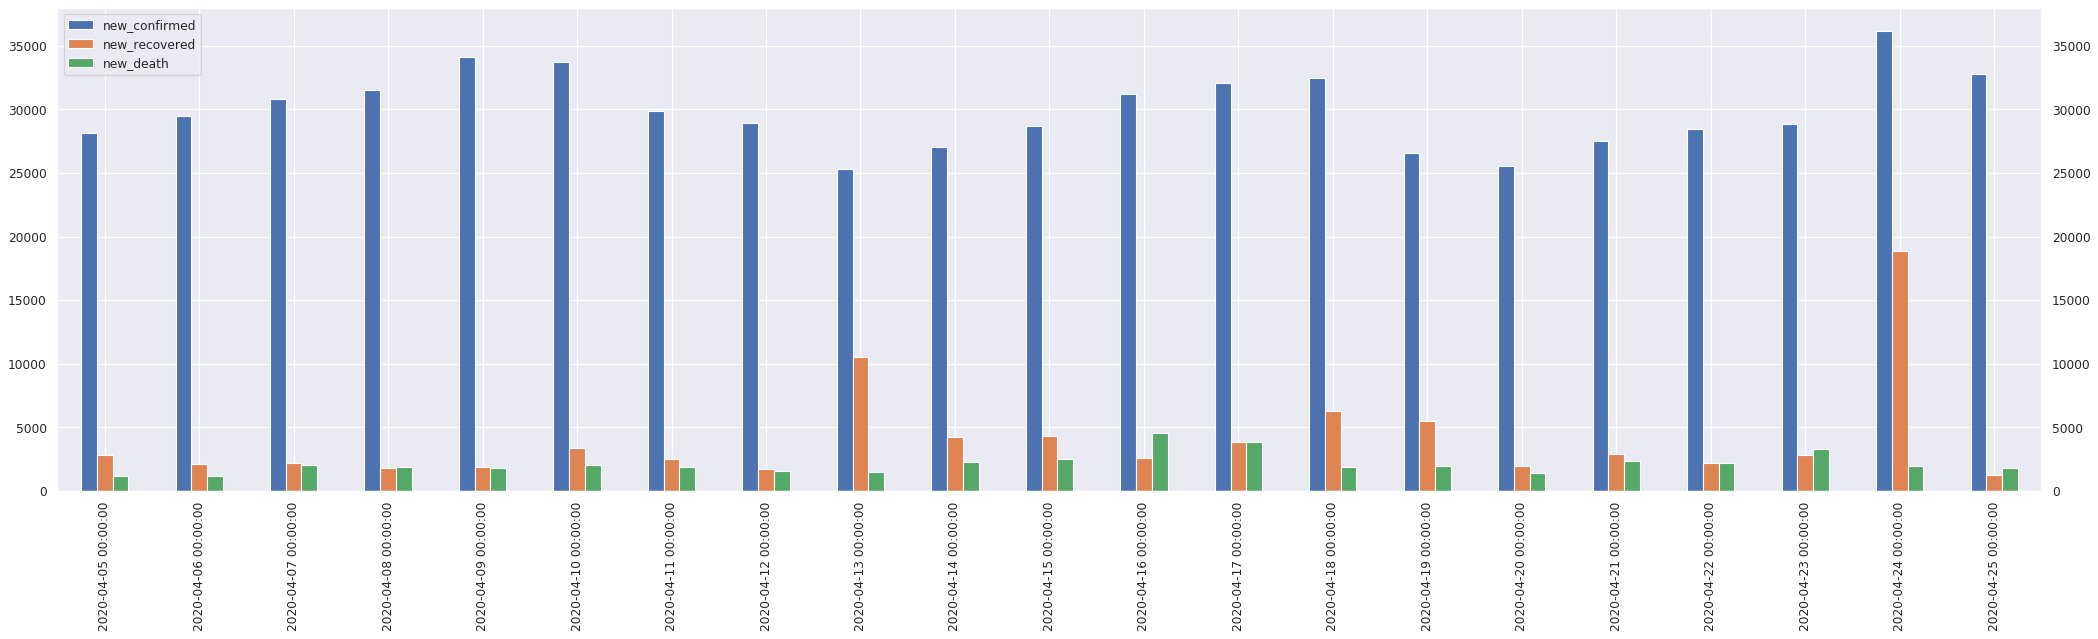

In [76]:
cbr_us.plot_daily_stats()

In [77]:
cbr_us.fit(first_date=pd.to_datetime('2020-03-11'))

sigmoid+linear: seor: 1999.449163787771, max asymptotic: 217237.2013386931; growth-rate: 0.03404927030357707, date:2020-06-03 00:00:00, projected value: 27861.322548994478


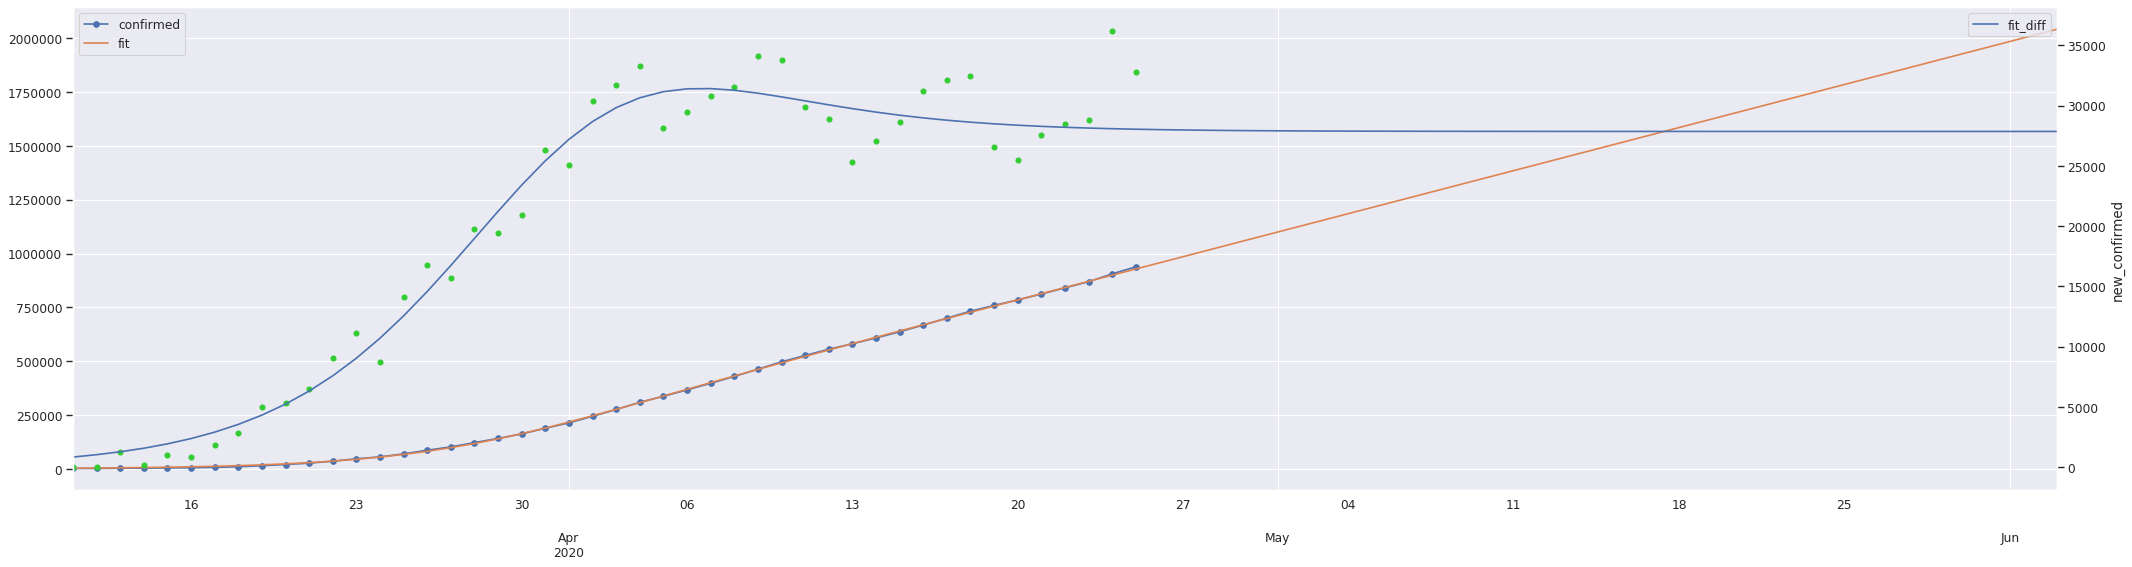

In [78]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_with_fits(ax=ax)

In [79]:
cbr_us.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,31417.039469


In [80]:
cbr_us.calculate_R_estimates()
cbr_us.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-23,0.97,0.897,0.954,1.286,1.051


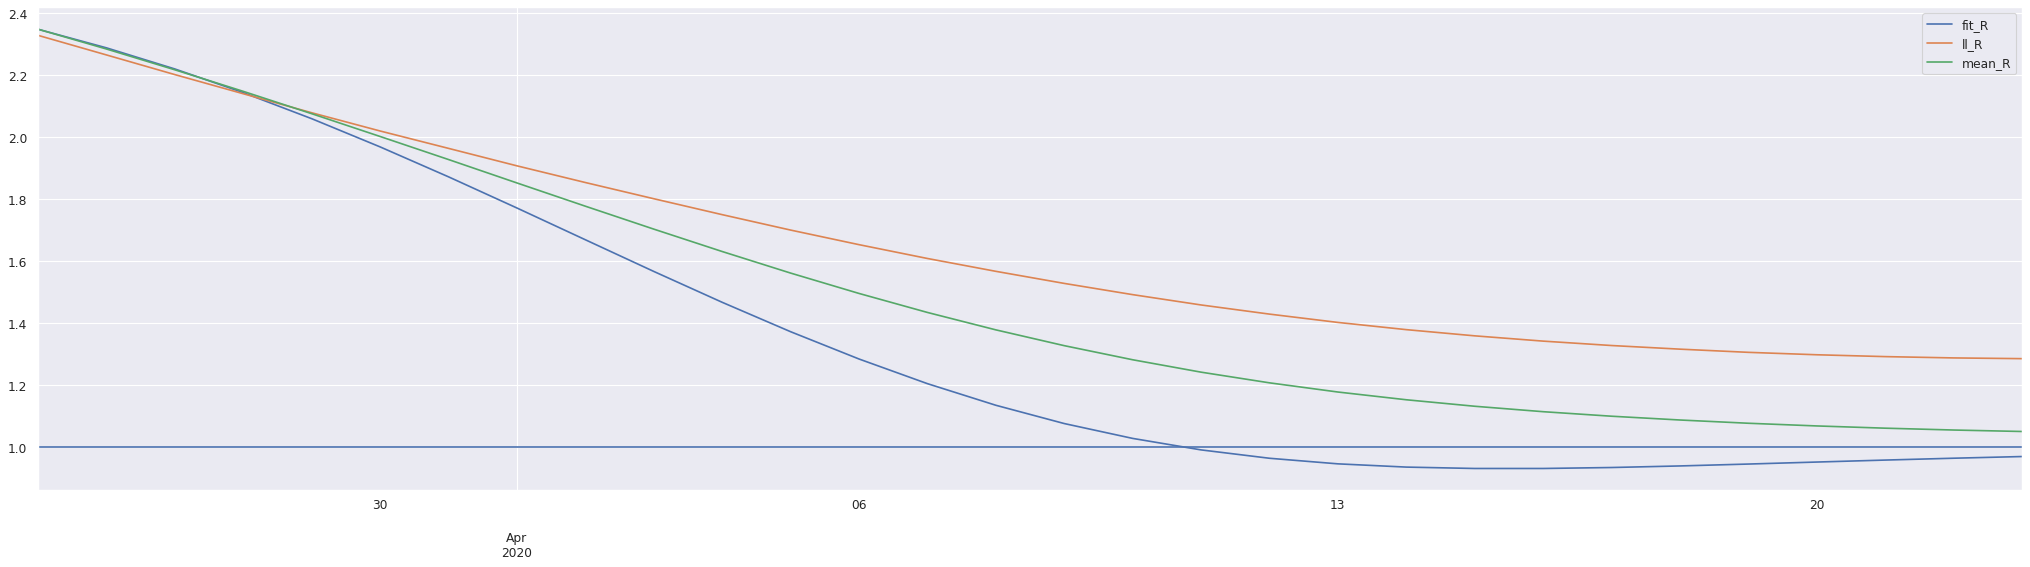

In [81]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [82]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,28063,19400,1478,119,800,49
2020-04-22,28268,19900,1509,205,500,31
2020-04-23,28496,20600,1549,228,700,40
2020-04-24,28677,21000,1589,181,400,40
2020-04-25,28894,21300,1599,217,300,10


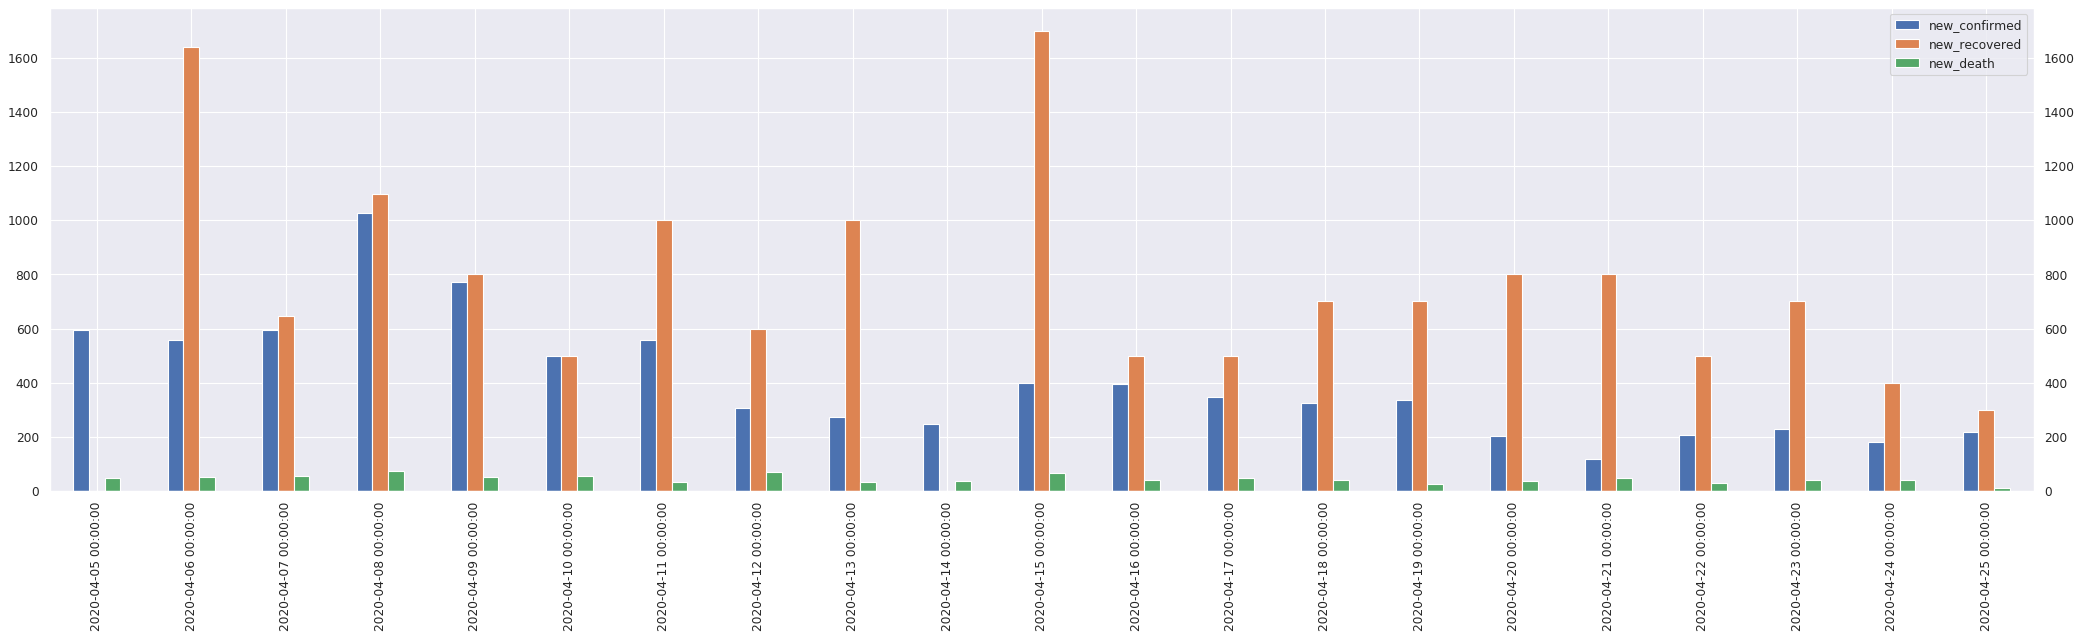

In [83]:
cbr_switzerland.plot_daily_stats()

In [84]:
cbr_switzerland.fit(first_date=pd.to_datetime('2020-03-05'))

sigmoid+asymmetric: seor: 183.6943149186406, max asymptotic: 30385.245306125224; growth-rate: 0.006550563270307119, date:2020-05-02 00:00:00, projected value: 89.04738046822189


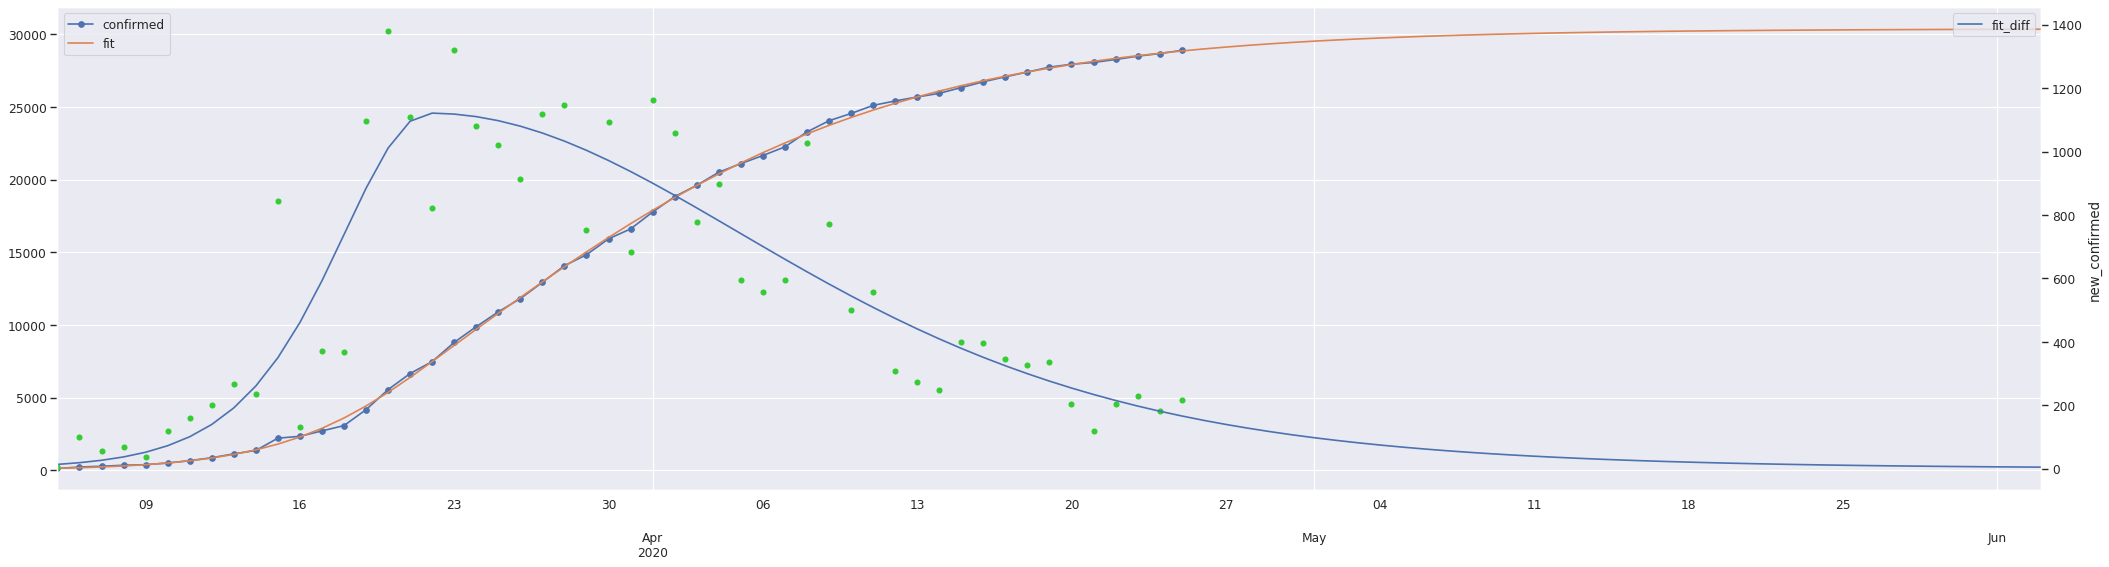

In [85]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_with_fits(ax=ax)

In [86]:
cbr_switzerland.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,1121.083717


In [87]:
cbr_switzerland.calculate_R_estimates()
cbr_switzerland.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-23,0.449,0.445,0.436,0.524,0.473


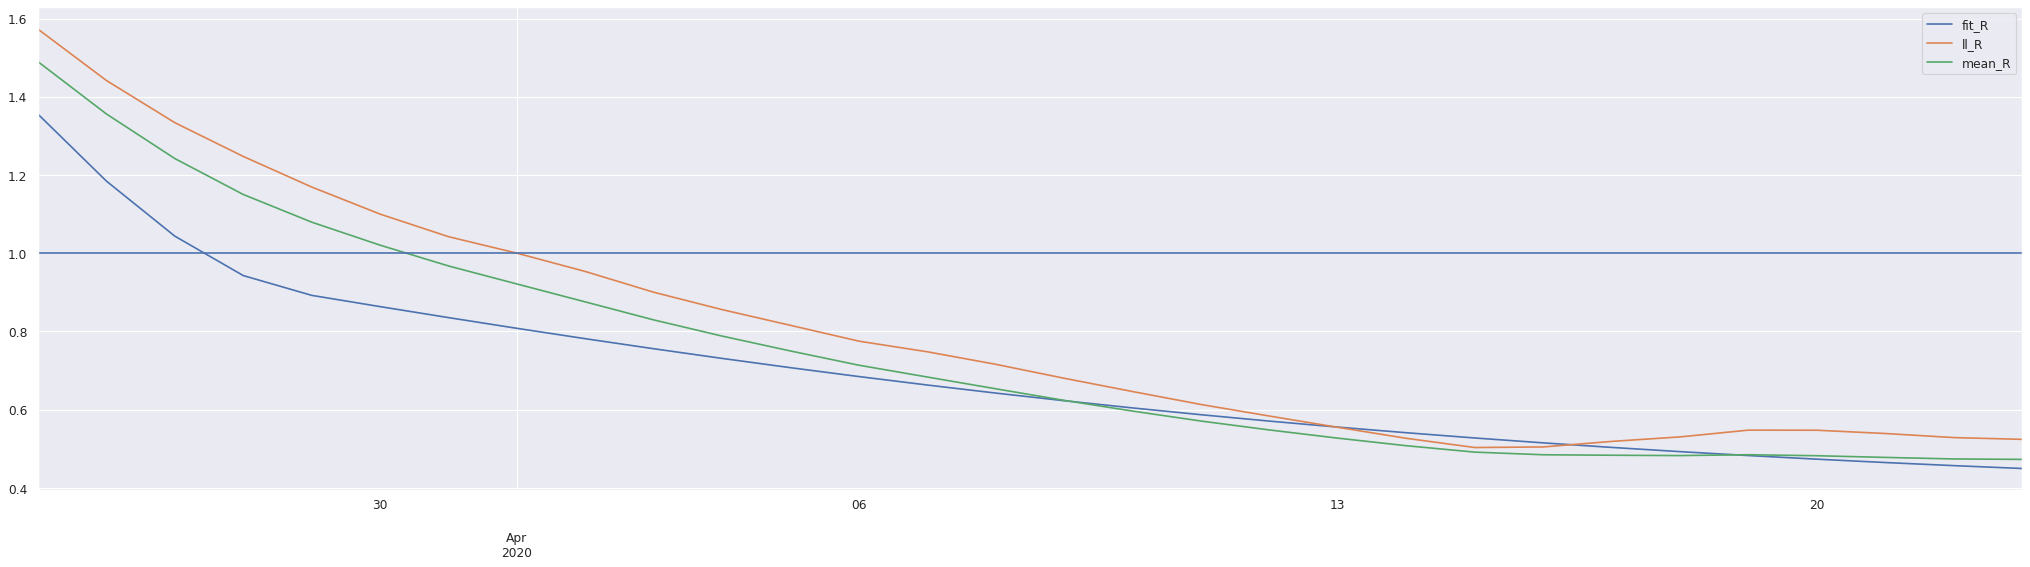

In [88]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [89]:
cbr_australia = covid19.CasesByRegion('Australia')
cbr_australia.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-21,6645,4124,67,22,0,0
2020-04-22,6652,4124,67,7,0,0
2020-04-23,6662,4124,75,10,0,8
2020-04-24,6677,4124,79,15,0,4
2020-04-25,6694,4223,80,17,99,1


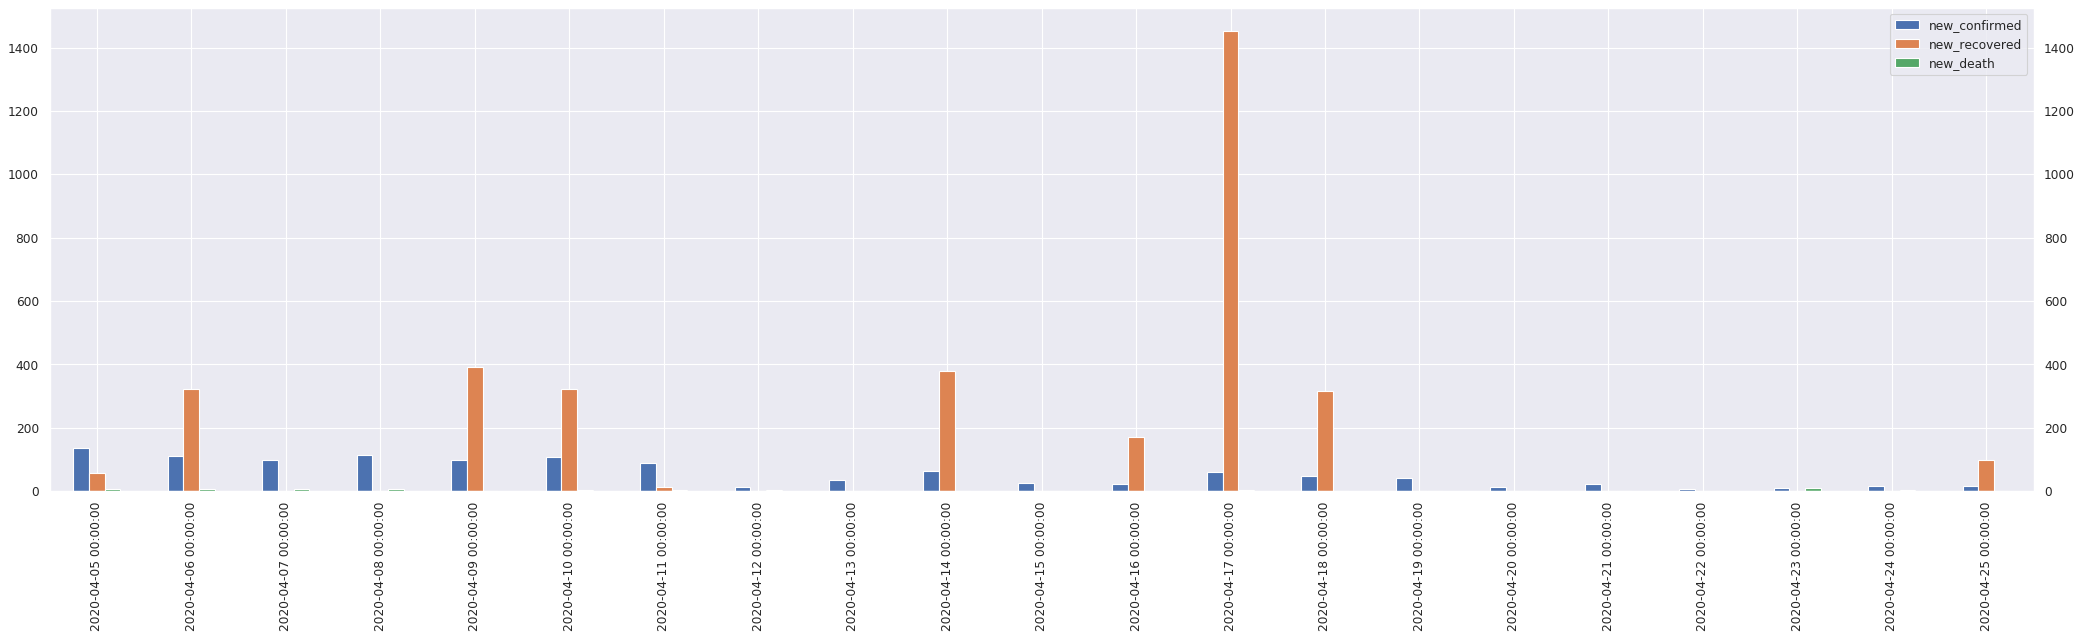

In [90]:
cbr_australia.plot_daily_stats()

In [91]:
cbr_australia.fit(first_date=pd.to_datetime('2020-03-10'))

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 58.176880199767794, max asymptotic: 6635.868221541054; growth-rate: 0.0010952986830816691, date:2020-04-10 00:00:00, projected value: 71.73754517517874


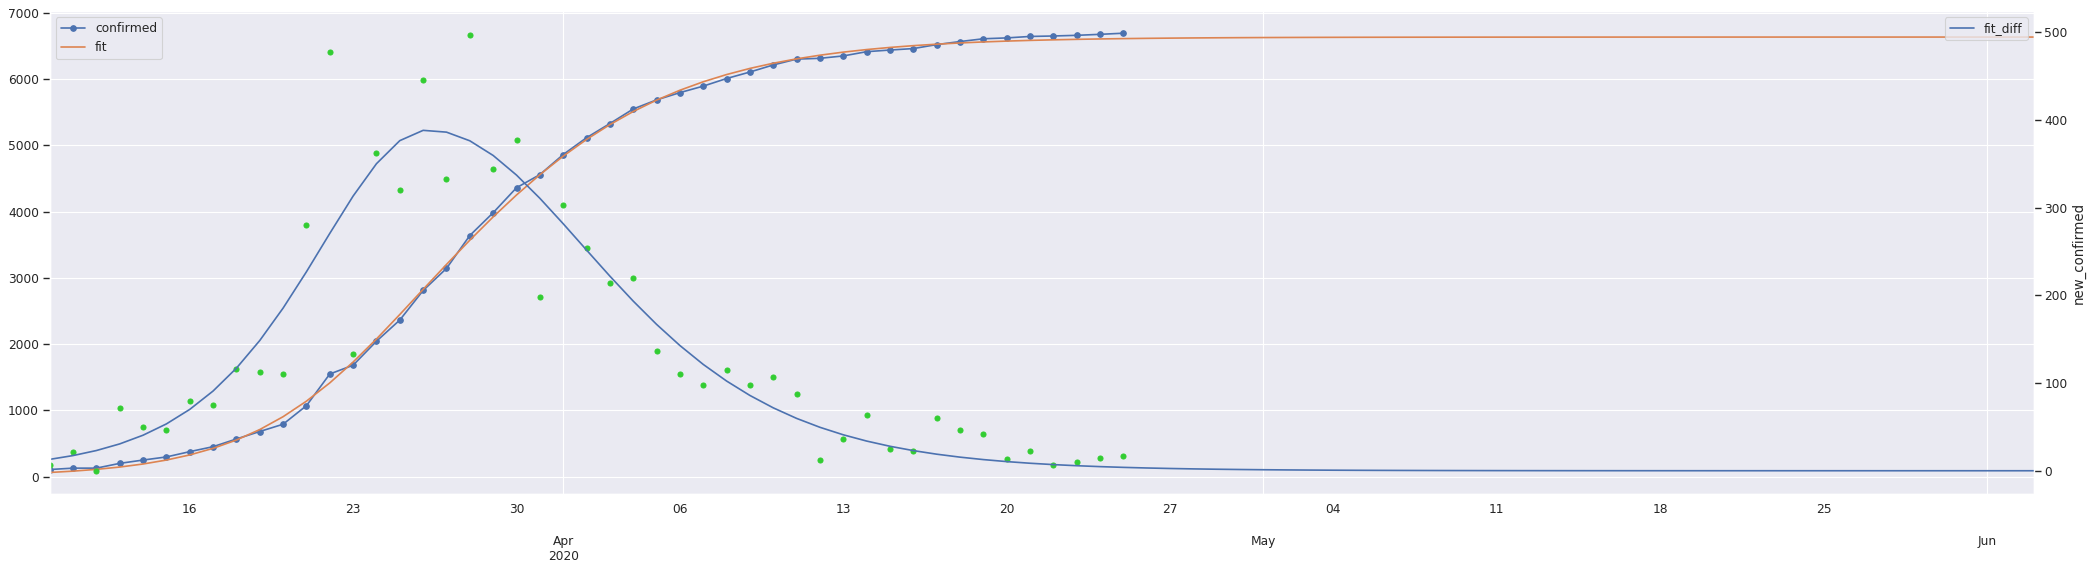

In [92]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_with_fits(ax=ax)

In [93]:
cbr_australia.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,388.199532


In [94]:
cbr_australia.calculate_R_estimates()
cbr_australia.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-04-23,0.0,0.574,0.523,0.407,0.327


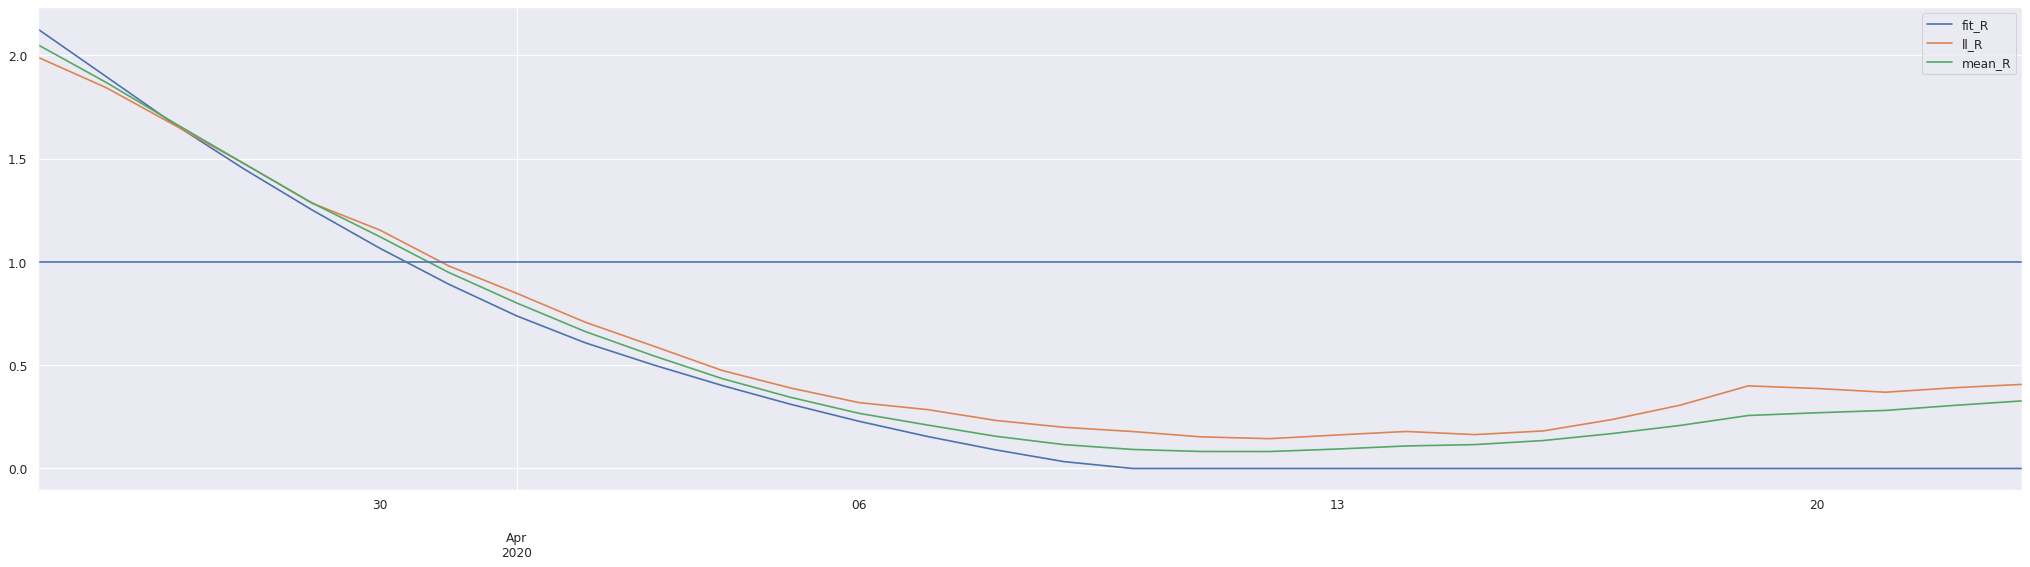

In [95]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [96]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-25,,,,,
Nicaragua,12,7,3,25.000000,27.272727
MS Zaandam,9,0,2,22.222222,66.666667
Belgium,45325,10417,6917,15.260894,39.901933
Mauritania,7,6,1,14.285714,12.500000
Bahamas,78,15,11,14.102564,40.740741


In [97]:
df_co[df_co.confirmed > 6500].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-04-25,,,,,
Belgium,45325,10417,6917,15.3,39.9
France,161644,45372,22648,14.0,33.3
United Kingdom,149569,774,20381,13.6,96.3
Italy,195351,63120,26384,13.5,29.5
Sweden,18177,1005,2192,12.1,68.5
Netherlands,37384,102,4424,11.8,97.7
Spain,223759,95708,22902,10.2,19.3
Mexico,13842,7149,1305,9.4,15.4
Indonesia,8607,1042,720,8.4,40.8
